# Problem:

For this particular assignment, the data of different types of wine sales in the 20th century is to be analysed. Both of these data are from the same company but of different wines. As an analyst in the ABC Estate Wines, you are tasked to analyse and forecast Wine Sales in the 20th century.

In [227]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from statsmodels.tools.eval_measures import rmse
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA # statsmodels.tsa.arima_model
from  statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima




## 1. Read the data as an appropriate Time Series data and plot the data.

**Importing data**

In [290]:
# reading the csv file into pandas dataframe

df_wine_rose = pd.read_csv('Rose.csv', parse_dates = ['YearMonth'], index_col = 'YearMonth')
display("Rose Wine", df_wine_rose.head(),)

'Rose Wine'

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

In [291]:
display('Rose Wine', df_wine_rose.tail() )

'Rose Wine'

Rose
YearMonth       
1995-03-01  45.0
1995-04-01  52.0
1995-05-01  28.0
1995-06-01  40.0
1995-07-01  62.0

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7

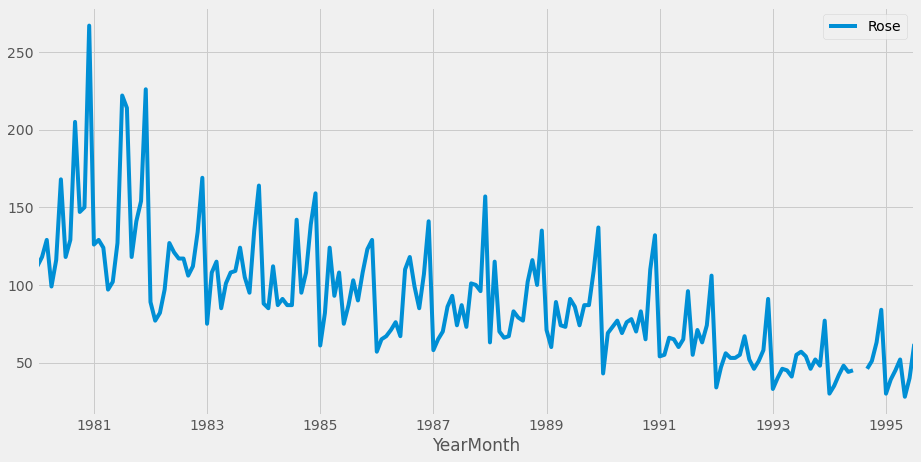

In [292]:
#Plot the time series
plt.style.use('fivethirtyeight')
df_wine_rose.plot()
plt.show()

**Insights**

•	Data values are stored in correct time order and no data is missing.

•	Intra-year stable fluctuations are indicative of seasonal component and decreasing Trend of sales of Rose Wine.

•	There is an indication of multiplicative seasonality as Trend & Seasonal component is very fluctuating.

 

In [5]:
df_wine_rose.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [6]:
df_wine_rose.describe()

Rose
count  185.000000
mean    90.394595
std     39.175344
min     28.000000
25%     63.000000
50%     86.000000
75%    112.000000
max    267.000000

## 2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

In [7]:
df_wine_rose.isnull().sum()

Rose    2
dtype: int64

### Missing Value Handling

In [35]:
df_wine_rose['1994']

Rose
YearMonth       
1994-01-01  30.0
1994-02-01  35.0
1994-03-01  42.0
1994-04-01  48.0
1994-05-01  44.0
1994-06-01  45.0
1994-07-01   NaN
1994-08-01   NaN
1994-09-01  46.0
1994-10-01  51.0
1994-11-01  63.0
1994-12-01  84.0

In [306]:
df_wine_rose.interpolate()['1994']

Rose
YearMonth            
1994-01-01  30.000000
1994-02-01  35.000000
1994-03-01  42.000000
1994-04-01  48.000000
1994-05-01  44.000000
1994-06-01  45.000000
1994-07-01  45.333333
1994-08-01  45.666667
1994-09-01  46.000000
1994-10-01  51.000000
1994-11-01  63.000000
1994-12-01  84.000000

In [307]:
df_wine_rose.iloc[174] = 45.33
df_wine_rose.iloc[175] = 45.66

In [310]:
df_wine_rose.isnull().sum()

Rose    0
dtype: int64

Using Linear interpolate method, we handled the missing value of Rose wine data

### Checking for duplicates

In [311]:
dups = df_wine_rose.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 89


### Year on Year Boxplot for Rose Wine production

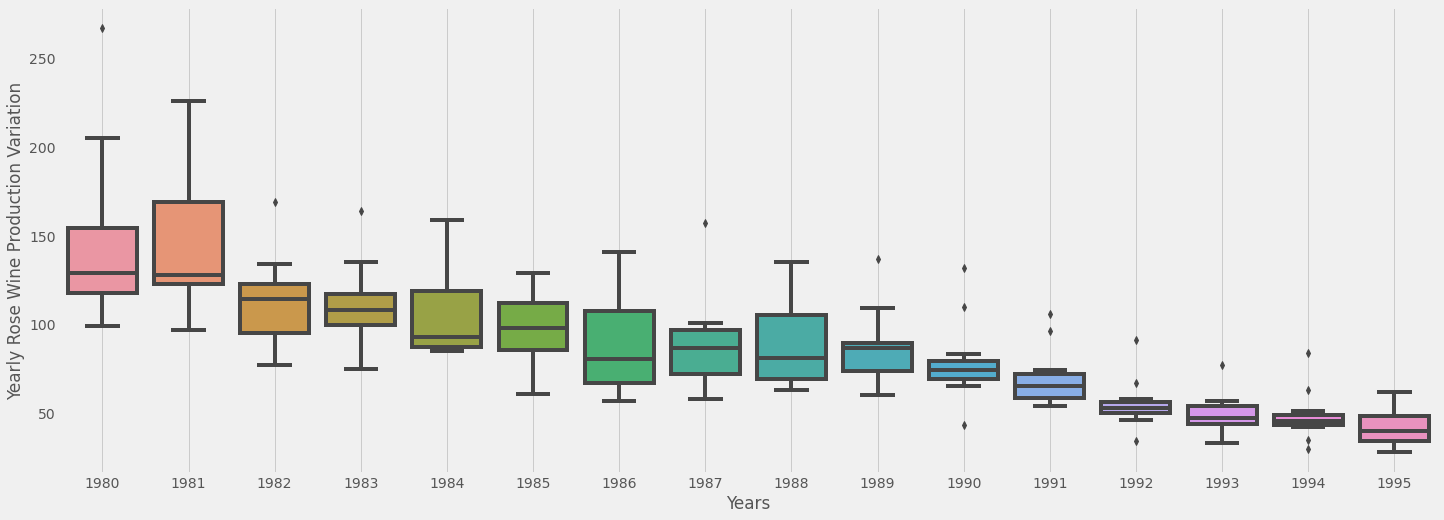

In [312]:
fig, ax = plt.subplots(figsize=(22,8))
sns.boxplot(df_wine_rose.index.year, df_wine_rose.Rose, ax=ax,whis=1.5)
plt.grid();
plt.xlabel('Years');
plt.ylabel('Yearly Rose Wine Production Variation');

**Insights**

 * As we got to know from the Time Series plot, the boxplots indicates a measure of trend being present. 
 * Also, we see that the production of wine has some outliers for certain years.
 

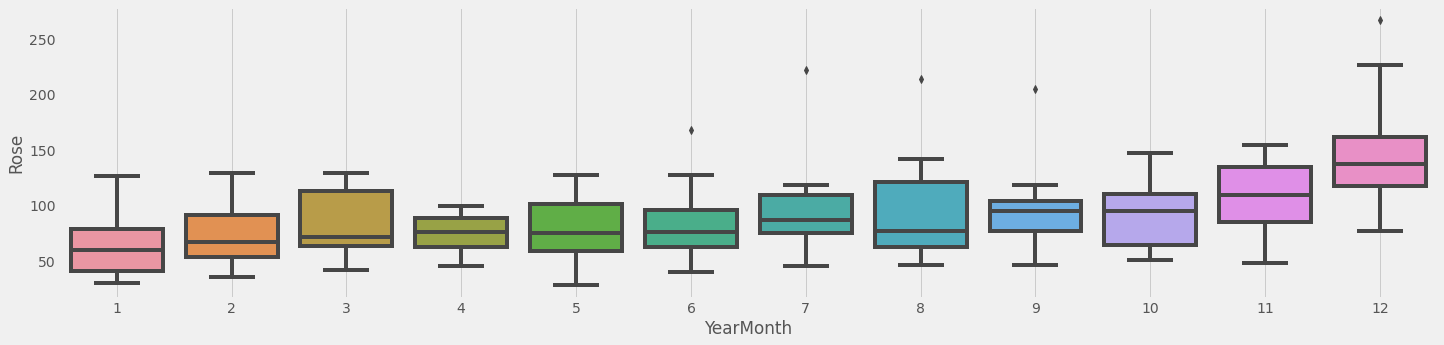

In [313]:
fig, ax = plt.subplots(figsize=(22,5))
sns.boxplot(df_wine_rose.index.month, df_wine_rose.Rose, ax=ax,whis=1.5)
plt.grid();

**Insights**

 * The boxplots for the monthly production for different years has many outliers


## Seasonal Plot

In [296]:
yearly_sales_across_years

YearMonth   1980   1981   1982   1983   1984   1985   1986   1987   1988  \
YearMonth                                                                  
January    112.0  126.0   89.0   75.0   88.0   61.0   57.0   58.0   63.0   
February   118.0  129.0   77.0  108.0   85.0   82.0   65.0   65.0  115.0   
March      129.0  124.0   82.0  115.0  112.0  124.0   67.0   70.0   70.0   
April       99.0   97.0   97.0   85.0   87.0   93.0   71.0   86.0   66.0   
May        116.0  102.0  127.0  101.0   91.0  108.0   76.0   93.0   67.0   
June       168.0  127.0  121.0  108.0   87.0   75.0   67.0   74.0   83.0   
July       118.0  222.0  117.0  109.0   87.0   87.0  110.0   87.0   79.0   
August     129.0  214.0  117.0  124.0  142.0  103.0  118.0   73.0   77.0   
September  205.0  118.0  106.0  105.0   95.0   90.0   99.0  101.0  102.0   
October    147.0  141.0  112.0   95.0  108.0  108.0   85.0  100.0  116.0   
November   150.0  154.0  134.0  135.0  139.0  123.0  107.0   96.0  100.0   
December   267.0  226.0  169.0  164.0  159.0  129.0  141.0  157.0  135.0   

YearMonth   1989   1990   1991  1992  1993  1994  1995  
YearMonth                                               
January     71.0   43.0   54.0  34.0  33.0  30.0  30.0  
February    60.0   69.0   55.0  47.0  40.0  35.0  39.0  
March       89.0   73.0   66.0  56.0  46.0  42.0  45.0  
April       74.0   77.0   65.0  53.0  45.0  48.0  52.0  
May         73.0   69.0   60.0  53.0  41.0  44.0  28.0  
June        91.0   76.0   65.0  55.0  55.0  45.0  40.0  
July        86.0   78.0   96.0  67.0  57.0   NaN  62.0  
August      74.0   70.0   55.0  52.0  54.0   NaN   NaN  
September   87.0   83.0   71.0  46.0  46.0  46.0   NaN  
October     87.0   65.0   63.0  51.0  52.0  51.0   NaN  
November   109.0  110.0   74.0  58.0  48.0  63.0   NaN  
December   137.0  132.0  106.0  91.0  77.0  84.0   NaN

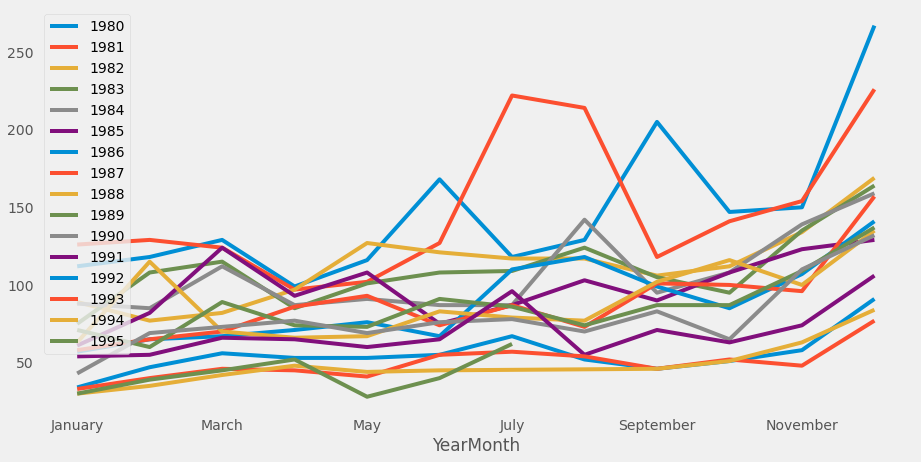

In [314]:
## Plot 1: Seasonal plot Year-wise 
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']
yearly_sales_across_years = pd.pivot_table(df_wine_rose, values = 'Rose', columns = df_wine_rose.index.year,index = df_wine_rose.index.month_name())
yearly_sales_across_years = yearly_sales_across_years.reindex(index = months)
yearly_sales_across_years.plot()
plt.grid()
plt.legend(loc='best');

**Insights**

* We can see that the Wine sales is seasonal. There is an increasing trend of sales at the end of November.
* There is an increasing sales in the month of November and December every year
* There is also an increase in sales in the month of July and August for the year 1981.

### Monthplot of the Rose Wine Time Series.

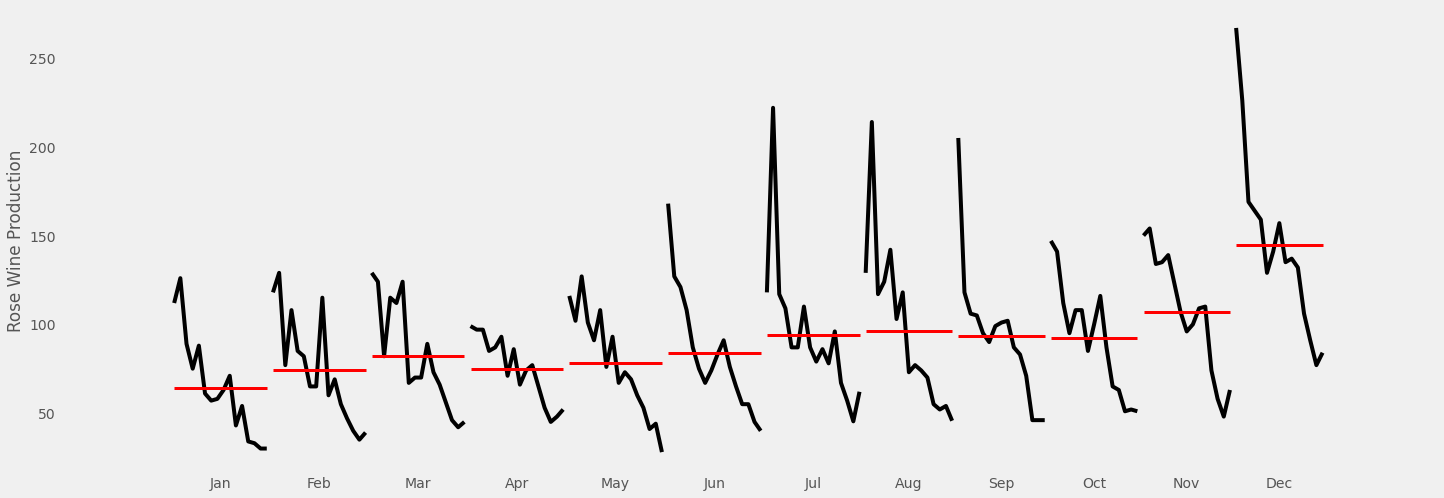

In [315]:
from statsmodels.graphics.tsaplots import month_plot
fig, ax = plt.subplots(figsize=(22,8))

month_plot(df_wine_rose,ylabel='Rose Wine Production',ax=ax)
plt.grid();

**Insights**

 * The "Red Line" indicates the Average production of Rose wine across 1980 to 1995. 
 * Rose wine has many fluctuations in every month across years.
 * We can see that there is variations in Trend across every month.
 * In December, the production of wine increases. And also the Average Production of Wine is higher for December. It can be because of Christmas & New Year.
 * The mean monthly production for January is the lowest. 
 * We can also observe that there is no Mean Production of wine for the month of July, August.

###  Time Series according to different months for different years of Rose Wine Production

In [318]:
yearly_sales_across_months_rose = pd.pivot_table(df_wine_rose, values = 'Rose', columns = df_wine_rose.index.month, 
                                        index = df_wine_rose.index.year)

yearly_sales_across_months_rose

YearMonth     1      2      3     4      5      6       7       8      9   \
YearMonth                                                                   
1980       112.0  118.0  129.0  99.0  116.0  168.0  118.00  129.00  205.0   
1981       126.0  129.0  124.0  97.0  102.0  127.0  222.00  214.00  118.0   
1982        89.0   77.0   82.0  97.0  127.0  121.0  117.00  117.00  106.0   
1983        75.0  108.0  115.0  85.0  101.0  108.0  109.00  124.00  105.0   
1984        88.0   85.0  112.0  87.0   91.0   87.0   87.00  142.00   95.0   
1985        61.0   82.0  124.0  93.0  108.0   75.0   87.00  103.00   90.0   
1986        57.0   65.0   67.0  71.0   76.0   67.0  110.00  118.00   99.0   
1987        58.0   65.0   70.0  86.0   93.0   74.0   87.00   73.00  101.0   
1988        63.0  115.0   70.0  66.0   67.0   83.0   79.00   77.00  102.0   
1989        71.0   60.0   89.0  74.0   73.0   91.0   86.00   74.00   87.0   
1990        43.0   69.0   73.0  77.0   69.0   76.0   78.00   70.00   83.0   
1991        54.0   55.0   66.0  65.0   60.0   65.0   96.00   55.00   71.0   
1992        34.0   47.0   56.0  53.0   53.0   55.0   67.00   52.00   46.0   
1993        33.0   40.0   46.0  45.0   41.0   55.0   57.00   54.00   46.0   
1994        30.0   35.0   42.0  48.0   44.0   45.0   45.33   45.66   46.0   
1995        30.0   39.0   45.0  52.0   28.0   40.0   62.00     NaN    NaN   

YearMonth     10     11     12  
YearMonth                       
1980       147.0  150.0  267.0  
1981       141.0  154.0  226.0  
1982       112.0  134.0  169.0  
1983        95.0  135.0  164.0  
1984       108.0  139.0  159.0  
1985       108.0  123.0  129.0  
1986        85.0  107.0  141.0  
1987       100.0   96.0  157.0  
1988       116.0  100.0  135.0  
1989        87.0  109.0  137.0  
1990        65.0  110.0  132.0  
1991        63.0   74.0  106.0  
1992        51.0   58.0   91.0  
1993        52.0   48.0   77.0  
1994        51.0   63.0   84.0  
1995         NaN    NaN    NaN

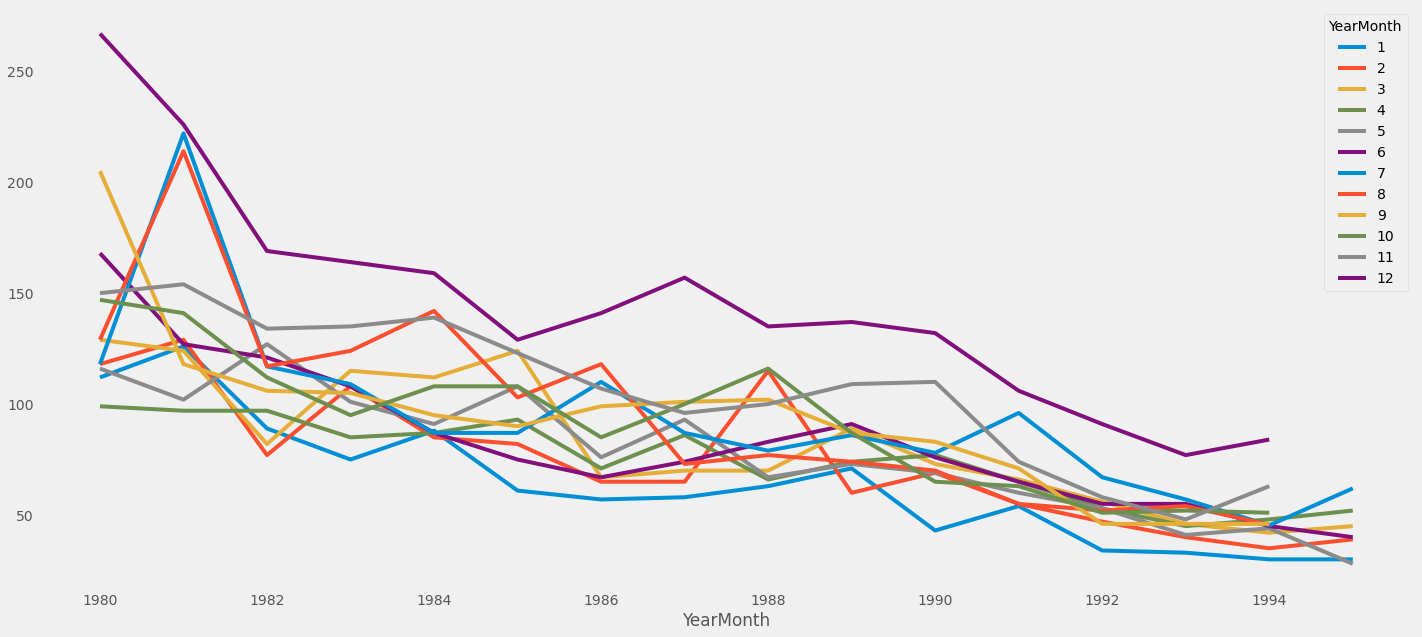

In [319]:
fig, ax = plt.subplots(figsize=(22,10))
yearly_sales_across_months_rose.plot(ax=ax)
plt.grid();

**Insights**

 * We can see that the Wine sales is above 250 in the month of December every year. 
 * It is the most least for the month of January.


### RESAMPLING - Monthly data of Rose Wine read into a quarterly, yearly, decadal, daily format


### Yearly Plot

Let us try to resample or aggregate the Time Series from an annual perspective and sum up the observations of each month.

In [320]:
df_yearly_sum_rose = df_wine_rose.resample('A').sum()
df_yearly_sum_rose.head()

Rose
YearMonth         
1980-12-31  1758.0
1981-12-31  1780.0
1982-12-31  1348.0
1983-12-31  1324.0
1984-12-31  1280.0

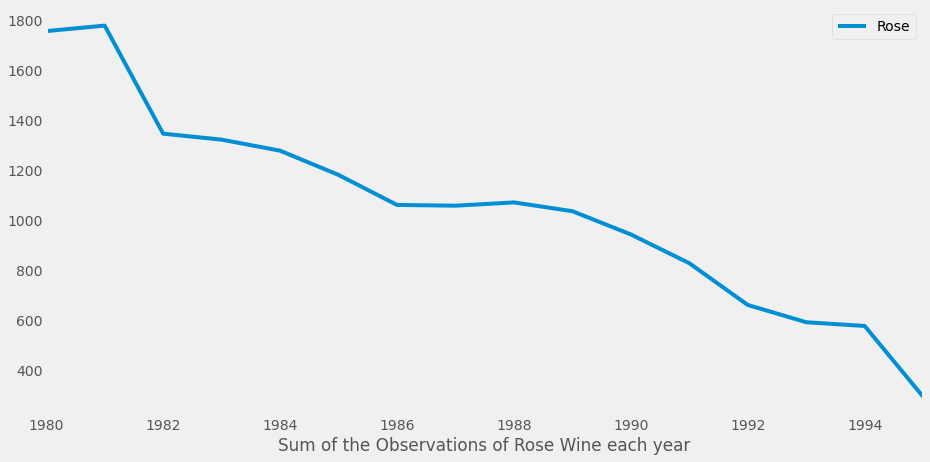

In [321]:
df_yearly_sum_rose.plot();
plt.grid()
plt.xlabel('Sum of the Observations of Rose Wine each year');

Inference

•	The resampled yearly or annual series have smoothened out the seasonality and have only been able to capture the year on year trend .
•	We can see that Yearly sales of wine has decreasing trend from 1986.


In [322]:
df_yearly_mean_rose = df_wine_rose.resample('Y').mean()
df_yearly_mean_rose.head()

Rose
YearMonth             
1980-12-31  146.500000
1981-12-31  148.333333
1982-12-31  112.333333
1983-12-31  110.333333
1984-12-31  106.666667

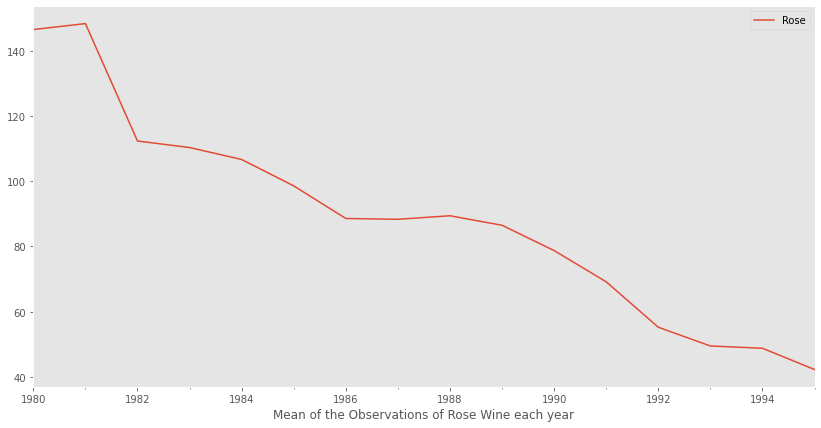

In [22]:
df_yearly_mean_rose.plot();
plt.grid()
plt.xlabel('Mean of the Observations of Rose Wine each year');

The resampled yearly or annual series have smoothened out the seasonality and have only been able to capture the year on year trend where there was

### Quarterly Plot

In [323]:
df_quarterly_sum_rose = df_wine_rose.resample('Q').sum()
df_quarterly_sum_rose.head()

Rose
YearMonth        
1980-03-31  359.0
1980-06-30  383.0
1980-09-30  452.0
1980-12-31  564.0
1981-03-31  379.0

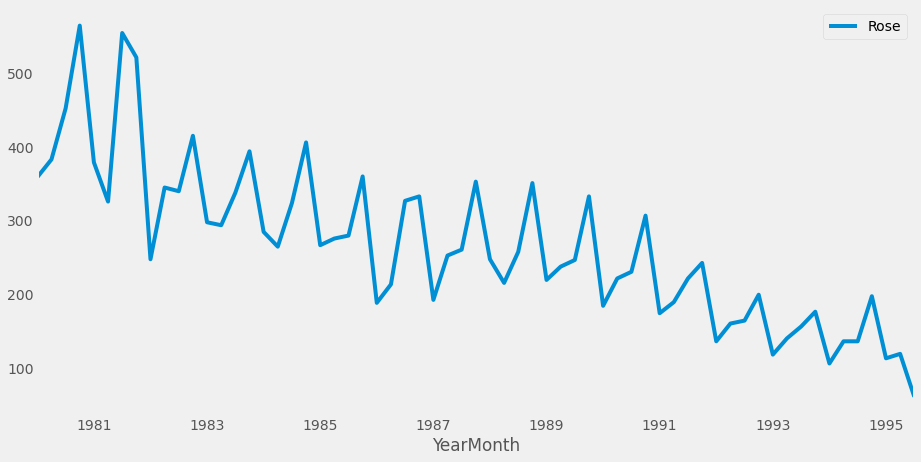

In [324]:
df_quarterly_sum_rose.plot();
plt.grid()

In [325]:
df_quarterly_mean_rose = df_wine_rose.resample('Q').mean()
df_quarterly_mean_rose.head()

Rose
YearMonth             
1980-03-31  119.666667
1980-06-30  127.666667
1980-09-30  150.666667
1980-12-31  188.000000
1981-03-31  126.333333

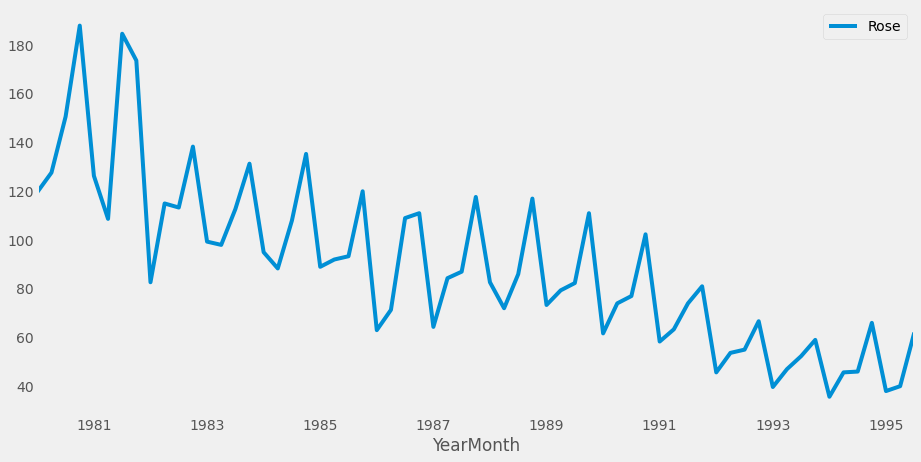

In [302]:
df_quarterly_mean_rose.plot();
plt.grid()

We see that the year on year quarterly series represents the year on year monthly series. The quarterly series is able to catch the seasonality in the data.

### Decade Plot

In [326]:
df_decade_sum_rose = df_wine_rose.resample('10Y').sum()
df_decade_sum_rose

Rose
YearMonth           
1980-12-31   1758.00
1990-12-31  12094.00
2000-12-31   2961.99

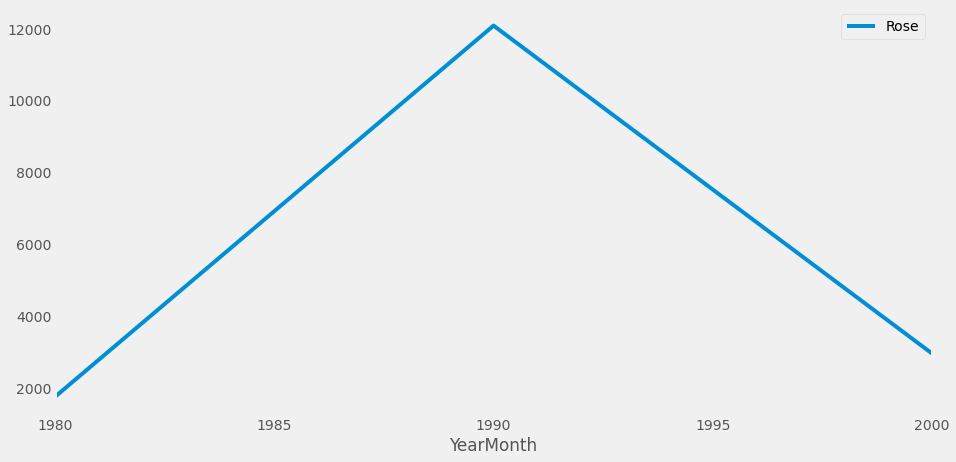

In [327]:
df_decade_sum_rose.plot();
plt.grid()

If we take the resampling period to be 10 years or a decade, we see that the seasonality present has been smoothed over and it is only giving an estimate of the trend.

### Daily Plot

Now, let us try to understand the data from a daily perspective.

In [328]:
df_daily_sum_rose = df_wine_rose.resample('D').sum()
df_daily_sum_rose

Rose
YearMonth        
1980-01-01  112.0
1980-01-02    0.0
1980-01-03    0.0
1980-01-04    0.0
1980-01-05    0.0
...           ...
1995-06-27    0.0
1995-06-28    0.0
1995-06-29    0.0
1995-06-30    0.0
1995-07-01   62.0

[5661 rows x 1 columns]

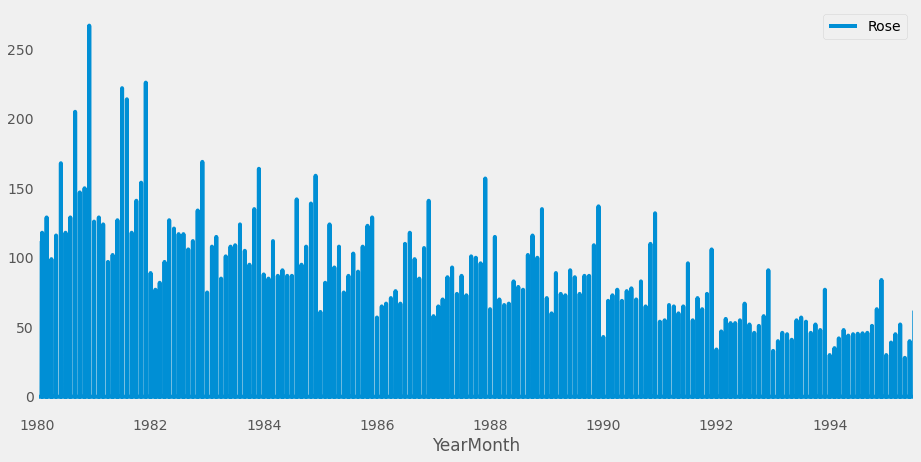

In [329]:
df_daily_sum_rose.plot()
plt.grid();

The above graph fails to give us a proper understanding of our data. Thus, resampling the data to intervals where a number of observations are 0 is not a good idea as that does not give us an understanding of the performance of the time series.

To get a very high-level overview of the trend of the Time Series Data (if Trend is present) can be understood by resampling the data keeping the intervals very large.

## Empirical Cumulative Distribution - Rose Wine

In [339]:
import plotly.express as px

plt.figure(figsize = (18, 8))
fig = px.ecdf(df_wine_rose, x="Rose");
fig.show();

<Figure size 1296x576 with 0 Axes>

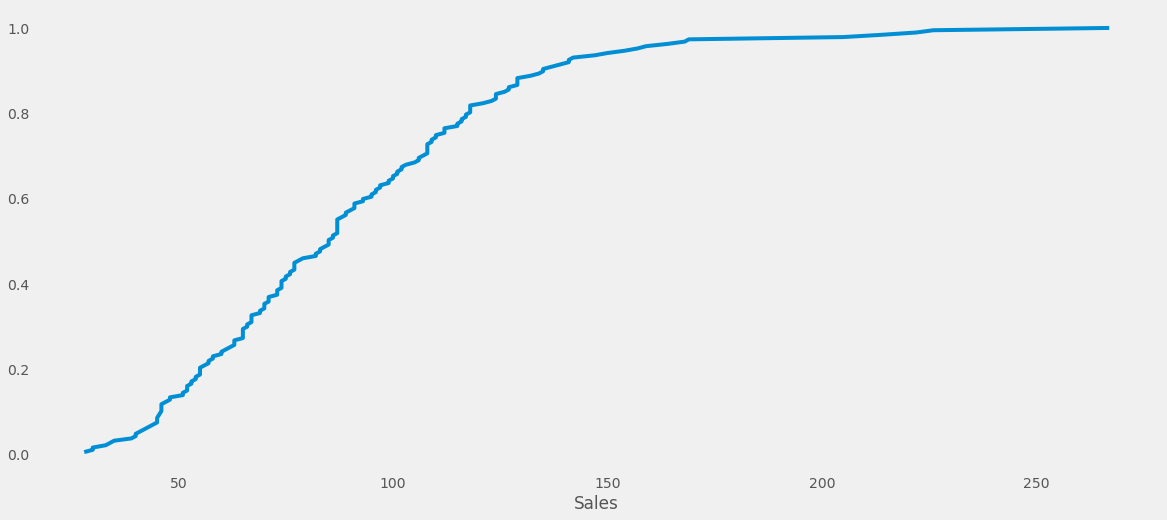

In [338]:
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize = (18, 8))
cdf = ECDF(df_wine_rose['Rose'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.grid()
plt.xlabel('Sales');

This particular graph tells us what percentage of data points refer to what number of Sales.

## Average Rose Wine Sales per month and the month on month percentage change of Wine sales

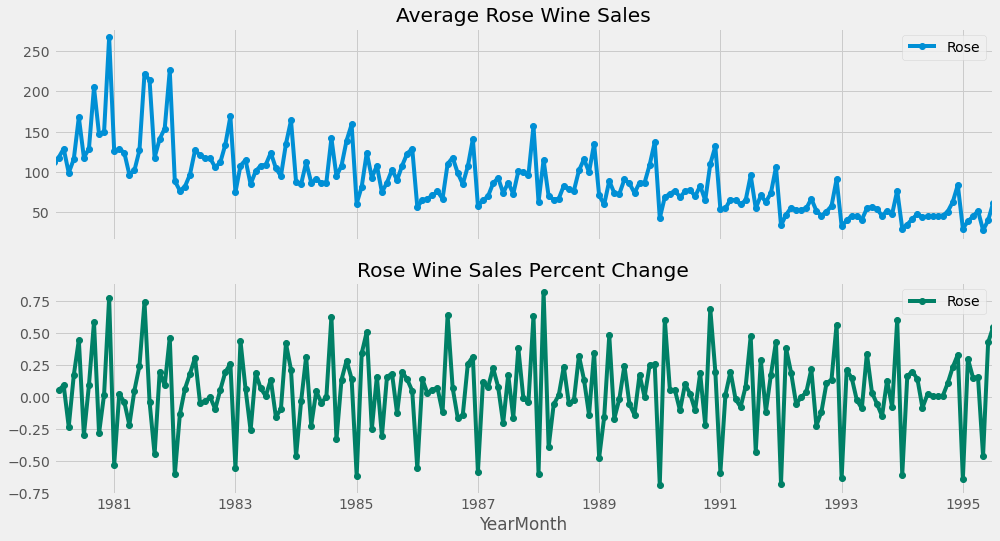

In [340]:
# group by date and get average RetailSales, and precent change
average    = df_wine_rose.groupby(df_wine_rose.index)["Rose"].mean()
pct_change = df_wine_rose.groupby(df_wine_rose.index)["Rose"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average RetailSales over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Rose Wine Sales",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for RetailSales over time(year-month)
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="Rose Wine Sales Percent Change",grid=True)

The above two graphs tells us the Average 'Rose Wine Sales' and the Percentage change of 'Rose Wine Sales' with respect to the time.

## Decomposing the Rose Wine Time Series

### Additive Model

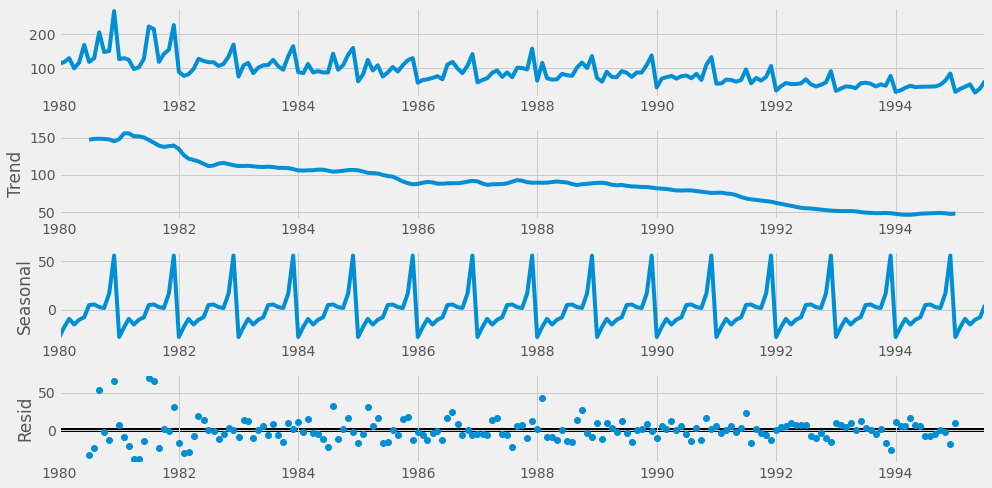

In [330]:
decomposition = seasonal_decompose(df_wine_rose, model='additive')
decomposition.plot();

As per the 'additive' decomposition, we see that there is a pronounced trend in the earlier years of the data. There is a seasonality as well.

In [331]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

In [332]:
print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-07-01    147.083333
1980-08-01    148.125000
1980-09-01    148.375000
1980-10-01    148.083333
1980-11-01    147.416667
1980-12-01    145.125000
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01   -27.908592
1980-02-01   -17.435592
1980-03-01    -9.285771
1980-04-01   -15.098271
1980-05-01   -10.196485
1980-06-01    -7.678628
1980-07-01     4.896741
1980-08-01     5.499297
1980-09-01     2.774741
1980-10-01     1.871964
1980-11-01    16.846964
1980-12-01    55.713630
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01          NaN
1980-02-01          NaN
1980-03-01          NaN
1980-04-01          NaN
1980-05-01          NaN
1980-06-01          NaN
1980-07-01   -33.980075
1980-08-01   -24.624297
1980-09-01    53.850259
1980-10-01    -2.955297
1980-11-01   -14.263630
1980-12-01    66.16137

In [42]:
deaseasonalized_ts = trend + residual
deaseasonalized_ts.head(12)

YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-07-01    113.103259
1980-08-01    123.500703
1980-09-01    202.225259
1980-10-01    145.128036
1980-11-01    133.153036
1980-12-01    211.286370
dtype: float64

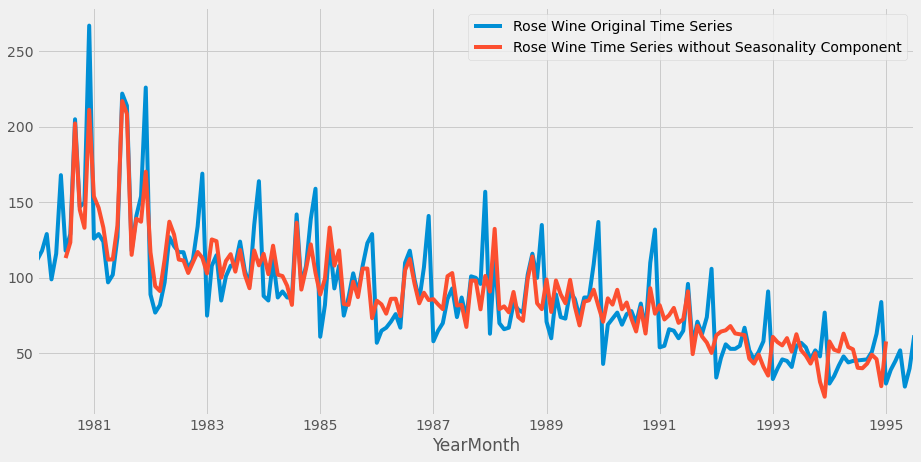

In [333]:
df_wine_rose.plot()
deaseasonalized_ts.plot()
plt.legend(["Rose Wine Original Time Series", "Rose Wine Time Series without Seasonality Component"]);

**Insight**

We can observe that this Time series data without seasonality gives a pattern which does not have seasonality and has random fluctuations.

### Multiplicative Model

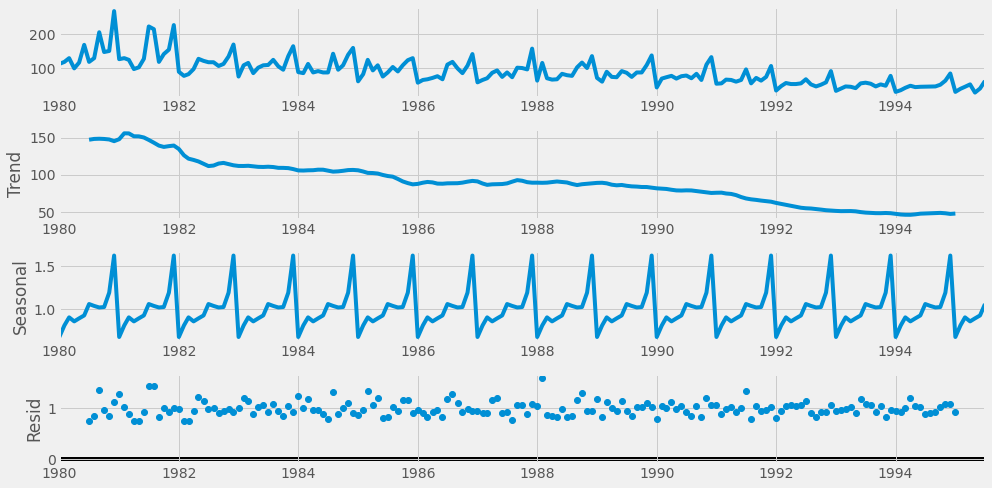

In [334]:
decomposition = seasonal_decompose(df_wine_rose,model='mltiplicative')
decomposition.plot();

In [335]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-07-01    147.083333
1980-08-01    148.125000
1980-09-01    148.375000
1980-10-01    148.083333
1980-11-01    147.416667
1980-12-01    145.125000
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01    0.670112
1980-02-01    0.806164
1980-03-01    0.901166
1980-04-01    0.854026
1980-05-01    0.889416
1980-06-01    0.923987
1980-07-01    1.058035
1980-08-01    1.035873
1980-09-01    1.017649
1980-10-01    1.022574
1980-11-01    1.192350
1980-12-01    1.628648
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01         NaN
1980-02-01         NaN
1980-03-01         NaN
1980-04-01         NaN
1980-05-01         NaN
1980-06-01         NaN
1980-07-01    0.758261
1980-08-01    0.840727
1980-09-01    1.357672
1980-10-01    0.970770
1980-11-01    0.853377
1980-12-01    1.129644
Name: resid, dtype: fl

In [336]:
deaseasonalized_ts = trend + residual
deaseasonalized_ts.head(12)

YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-07-01    147.841594
1980-08-01    148.965727
1980-09-01    149.732672
1980-10-01    149.054103
1980-11-01    148.270044
1980-12-01    146.254644
dtype: float64

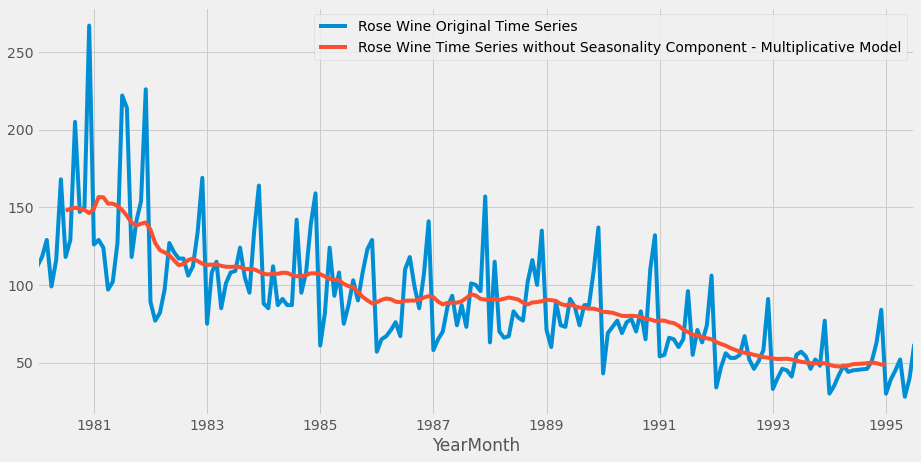

In [337]:
df_wine_rose.plot()
deaseasonalized_ts.plot()
plt.legend(["Rose Wine Original Time Series", "Rose Wine Time Series without Seasonality Component - Multiplicative Model"]);

**Insights**

 * We can observe that this Time series data without seasonality gives a straight line in decreasing trend.

## 3. Split the data into training and test. The test data should start in 1991.

**Training Data is till the end of 1990. Test Data is from the beginning of 1991 to the last time stamp provided.**

### Rose Wine

In [341]:
train_rose=df_wine_rose[df_wine_rose.index.year < 1991]
test_rose=df_wine_rose[df_wine_rose.index.year >= 1991]

In [342]:
display("Train data shape of Rose wine ",train_rose.shape)
display("Test data shape of Rose wine ",test_rose.shape)

'Train data shape of Rose wine '

(132, 1)

'Test data shape of Rose wine '

(55, 1)

In [343]:
print('First few rows of Rose Wine Train Data')
display(train_rose.head())
print('Last few rows of Rose Wine Train Data')
display(train_rose.tail())
print('First few rows of Rose Wine Test Data')
display(test_rose.head())
print('Last few rows of Rose Wine Test Data')
display(test_rose.tail())

First few rows of Rose Wine Train Data


Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

Last few rows of Rose Wine Train Data


Rose
YearMonth        
1990-08-01   70.0
1990-09-01   83.0
1990-10-01   65.0
1990-11-01  110.0
1990-12-01  132.0

First few rows of Rose Wine Test Data


Rose
YearMonth       
1991-01-01  54.0
1991-02-01  55.0
1991-03-01  66.0
1991-04-01  65.0
1991-05-01  60.0

Last few rows of Rose Wine Test Data


Rose
YearMonth       
1995-03-01  45.0
1995-04-01  52.0
1995-05-01  28.0
1995-06-01  40.0
1995-07-01  62.0

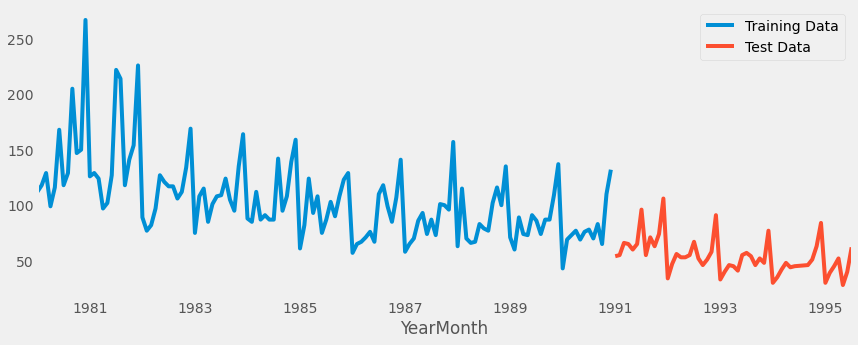

In [344]:
train_rose['Rose'].plot(figsize=(13,5), fontsize=14)
test_rose['Rose'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

From our train-test split we are predicting likewise behaviour as compared to the past years.

## 4. Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models such as regression,naïve forecast models and simple average models. should also be built on the training data and check the performance on the test data using RMSE.

### Simple Exponential Smoothing Model





### Rose Wine data

In [52]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [345]:
SES_train_rose = train_rose.copy()
SES_test_rose = test_rose.copy()

In [346]:
len(SES_train_rose)

132

In [347]:
model_SES_rose = SimpleExpSmoothing(SES_train_rose['Rose'])
model_SES_autofit_rose = model_SES_rose.fit()
model_SES_autofit_rose.params

{'smoothing_level': 0.0987493111726833,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.38720226208358,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [348]:
SES_test_rose['predict'] = model_SES_autofit_rose.forecast(steps=len(test_rose))
SES_test_rose.head()

Rose    predict
YearMonth                  
1991-01-01  54.0  87.104983
1991-02-01  55.0  87.104983
1991-03-01  66.0  87.104983
1991-04-01  65.0  87.104983
1991-05-01  60.0  87.104983

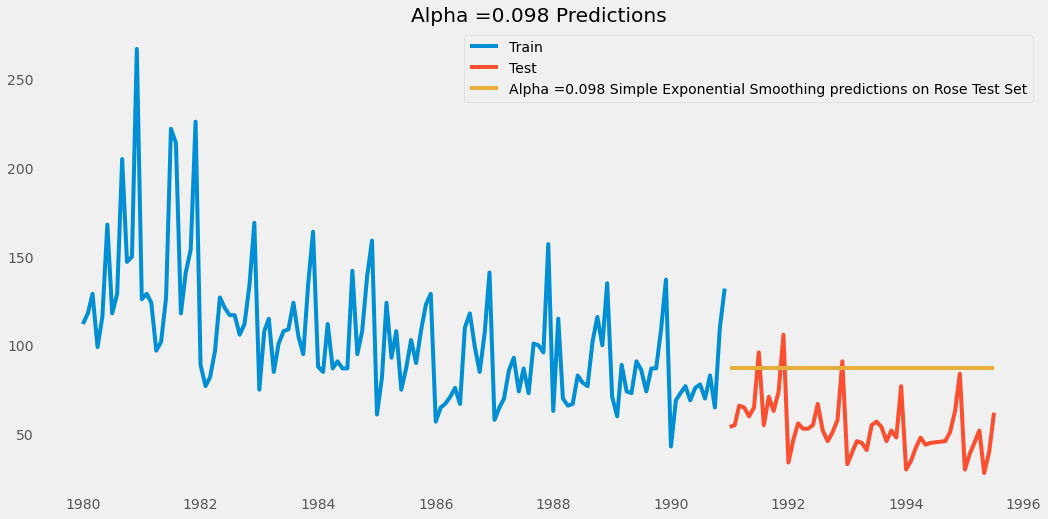

In [349]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train_rose['Rose'], label='Train')
plt.plot(SES_test_rose['Rose'], label='Test')

plt.plot(SES_test_rose['predict'], label='Alpha =0.098 Simple Exponential Smoothing predictions on Rose Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.098 Predictions');

### Model Evaluation for 𝛼 = 0.098 : Simple Exponential Smoothing

In [350]:
## Test Data
from sklearn import metrics
rmse_ses_rose = metrics.mean_squared_error(SES_test_rose['Rose'],SES_test_rose['predict'],squared=False)
print("For Alpha =0.098 Simple Exponential Smoothing Model forecast on the Rose Wine Test Data, RMSE is %3.3f" %(rmse_ses_rose))


For Alpha =0.098 Simple Exponential Smoothing Model forecast on the Rose Wine Test Data, RMSE is 36.796


In [351]:
results = pd.DataFrame({'Test RMSE': [rmse_ses_rose]},index=['Alpha=0.098,SimpleExponentialSmoothing-Rose Wine'])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine  36.796433

**Setting different alpha values:**

The higher the alpha value more weightage is given to the more recent observation. That means, what happened recently will happen again.

We will run a loop with different alpha values to understand which particular value works best for alpha on the test set.

In [352]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_6

Empty DataFrame
Columns: [Alpha Values, Train RMSE, Test RMSE]
Index: []

In [353]:
alpha_list = [0.3,0.4,0.5,0.6,0.7,0.8,0.9] 

In [354]:
from statsmodels.tools.eval_measures import rmse 

for i in alpha_list:
    model_SES_alpha_i = model_SES_rose.fit(smoothing_level=i)
    
    SES_train_rose['predict',i] = model_SES_alpha_i.fittedvalues.round(0)
    SES_test_rose['predict',i] = model_SES_alpha_i.forecast(steps=len(test_rose)).round(0)
    
    rmse_model5_train_i = metrics.mean_squared_error(SES_train_rose['Rose'],SES_train_rose['predict',i],squared=False)
    
    rmse_model5_test_i = metrics.mean_squared_error(SES_test_rose['Rose'],SES_test_rose['predict',i],squared=False)
    
    resultsDf_6 = resultsDf_6.append({'Alpha Values':i,
                                      'Train RMSE': rmse_model5_train_i,
                                      'Test RMSE':rmse_model5_test_i}, 
                                     ignore_index=True)

In [355]:
SES_test_rose.head()

Rose    predict  (predict, 0.3)  (predict, 0.4)  (predict, 0.5)  \
YearMonth                                                                     
1991-01-01  54.0  87.104983            99.0           105.0           111.0   
1991-02-01  55.0  87.104983            99.0           105.0           111.0   
1991-03-01  66.0  87.104983            99.0           105.0           111.0   
1991-04-01  65.0  87.104983            99.0           105.0           111.0   
1991-05-01  60.0  87.104983            99.0           105.0           111.0   

            (predict, 0.6)  (predict, 0.7)  (predict, 0.8)  (predict, 0.9)  
YearMonth                                                                   
1991-01-01           117.0           122.0           126.0           129.0  
1991-02-01           117.0           122.0           126.0           129.0  
1991-03-01           117.0           122.0           126.0           129.0  
1991-04-01           117.0           122.0           126.0           129.0  
1991-05-01           117.0           122.0           126.0           129.0

**Model Evaluation**

In [356]:
resultsDf_6.sort_values(by=['Test RMSE'],ascending=True)

Alpha Values  Train RMSE  Test RMSE
0           0.3   32.478198  47.817385
1           0.4   32.971062  53.518687
2           0.5   33.690436  59.278981
3           0.6   34.440660  65.082603
4           0.7   35.323612  69.944275
5           0.8   36.365256  73.846913
6           0.9   37.497677  76.780469

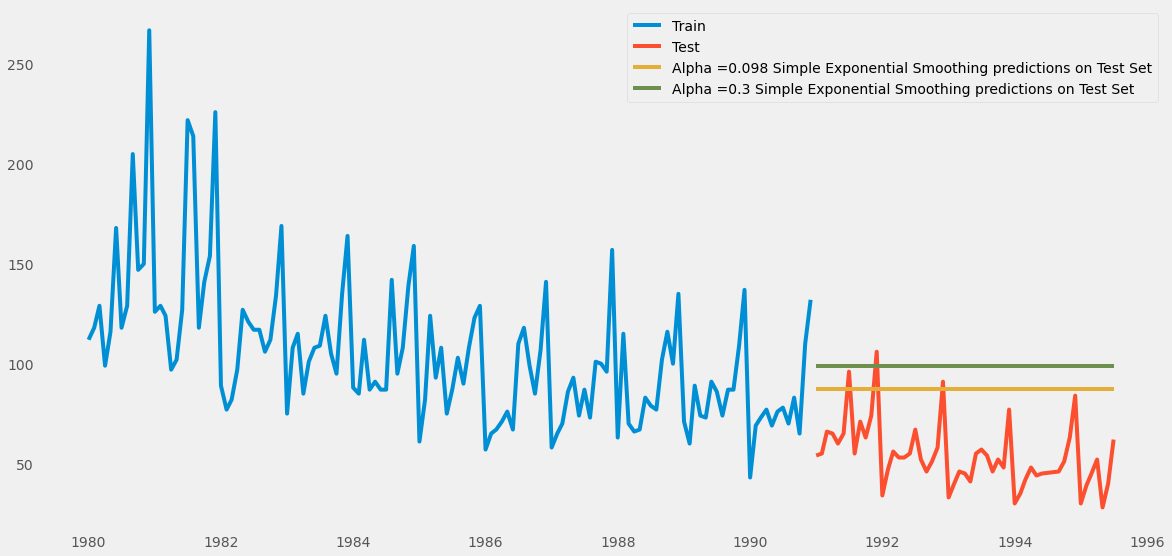

In [358]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(SES_train_rose['Rose'], label='Train')
plt.plot(SES_test_rose['Rose'], label='Test')

plt.plot(SES_test_rose['predict'], label='Alpha =0.098 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_test_rose['predict', 0.3], label='Alpha =0.3 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid();

In [359]:
resultsDf_6_1 = pd.DataFrame({'Test RMSE': [resultsDf_6.sort_values(by=['Test RMSE'], ascending=True).values[0][2]]}, 
                             index = ['Alpha=0.3,SimpleExponentialSmoothing - Rose Wine'])

results = pd.concat([results, resultsDf_6_1])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine  36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine  47.817385

**Inference**

* We can see that at Alpha = 0.098, the Single Exponential Smoothing (SES) Model works better than at Alpha = 0.3.



### Double Exponential Smoothing (Holt's Model)


Two parameters  𝛼   and  𝛽   are estimated in this model. Level and Trend are accounted for in this model.

### Rose Wine data

In [360]:
# Initializing the Double Exponential Smoothing Model
model_DES_init = Holt(train_rose,initialization_method='estimated')
# Fitting the model
model_DES_init = model_DES_init.fit()

print('')
print('==Holt model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_DES_init.params)


==Holt model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 1.4901161193847656e-08, 'smoothing_trend': 1.6610391146660035e-10, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 137.81553690867275, 'initial_trend': -0.4943781897068274, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [361]:
# Forecasting using this model for the duration of the test set
DES_predict_init =  model_DES_init.forecast(len(test_rose))

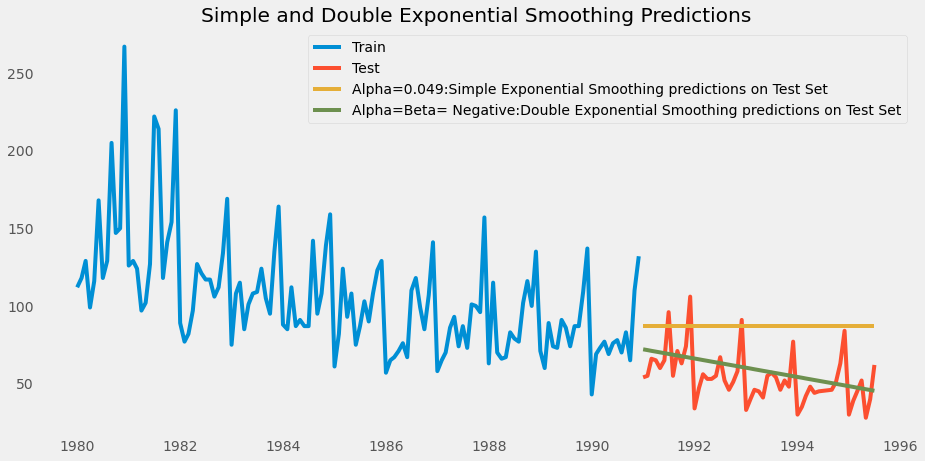

In [362]:
## Plotting the Training data, Test data and the forecasted values

plt.plot(train_rose, label='Train')
plt.plot(test_rose, label='Test')

plt.plot(SES_test_rose['predict'], label='Alpha=0.049: Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict_init, label='Alpha=Beta= Negative: Double Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple and Double Exponential Smoothing Predictions');

**Inference**

Here, we see that the Double Exponential Smoothing has actually performed well when compared to the Simple Exponential Smoothing. This is because of the fact that the Double Exponential Smoothing model has picked up the trend and Level component.

In [363]:
rmse_des_init = rmse(test_rose['Rose'],DES_predict_init.values)
print('DES RMSE at Alpha= Beta= Negative :',rmse_des_init)

DES RMSE at Alpha= Beta= Negative : 15.269008268261677


In [380]:
results_des_init = pd.DataFrame({'Test RMSE': rmse_des_init }, 
                             index = ['Alpha = Beta= Negative,SimpleExponentialSmoothing - Rose Wine'])

results = pd.concat([results, results_des_init])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008

### Identifying Optimum Values of 𝛼 & 𝛽

In [365]:
DES_train_rose = train_rose.copy()
DES_test_rose = test_rose.copy()
model_DES_rose = Holt(DES_train_rose['Rose'])

**Identifying Optimum Values of  𝛼 &  𝛽**

In [366]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7

Empty DataFrame
Columns: [Alpha Values, Beta Values, Train RMSE, Test RMSE]
Index: []

In [371]:
alpha_list = [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
beta_list = [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [372]:
for i in alpha_list:
    for j in beta_list:
        model_DES_alpha_i_j = model_DES_rose.fit(smoothing_level=i,smoothing_trend=j)
        
        DES_train_rose['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test_rose['predict',i,j] = model_DES_alpha_i_j.forecast(steps=len(test_rose))
        
        rmse_model6_train =  rmse(DES_train_rose['Rose'],DES_train_rose['predict',i,j])#,squared=False)
        
        rmse_model6_test =  rmse(DES_test_rose['Rose'],DES_test_rose['predict',i,j])#,squared=False)
        
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,
                                          'Beta Values':j,
                                          'Train RMSE': rmse_model6_train,
                                          'Test RMSE': rmse_model6_test}, ignore_index=True)

In [373]:
resultsDf_7.sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values  Train RMSE  Test RMSE
73           0.0          1.0   30.718135  15.269016
65           0.0          0.2   30.718135  15.269018
67           0.0          0.4   30.718135  15.269019
64           0.0          0.0   30.718135  15.269023
66           0.0          0.3   30.718135  15.269025

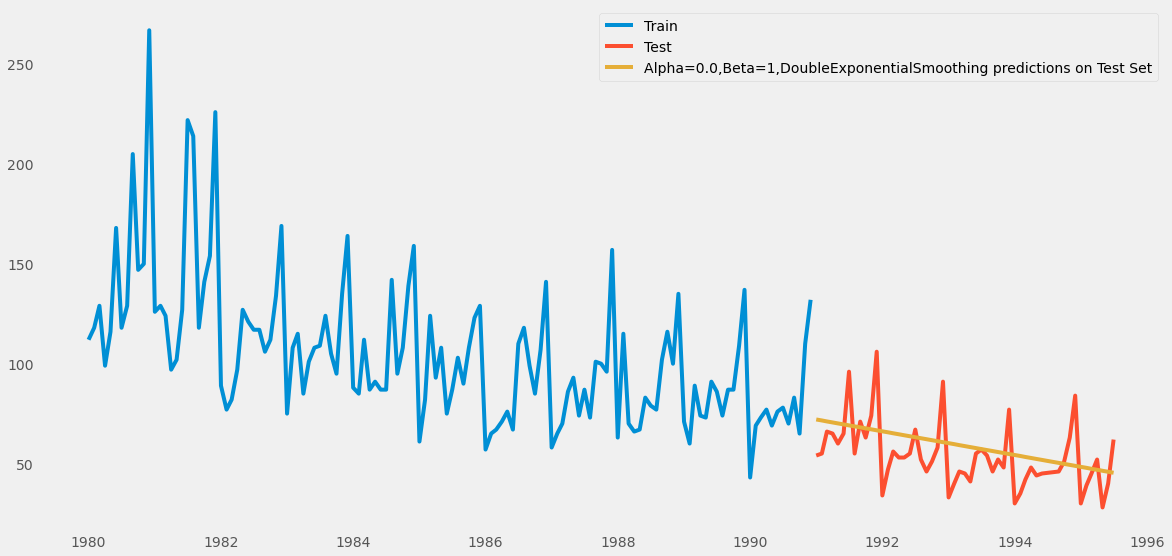

In [382]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train_rose['Rose'], label='Train')
plt.plot(DES_test_rose['Rose'], label='Test')

plt.plot(DES_test_rose['predict', 0.0, 1.0],
         label='Alpha=0.0,Beta=1,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [384]:
rmse_des_init_1 = resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]
print('DES RMSE at Alpha= 0.0 Beta= 1.0 :',rmse_des_init_1)

DES RMSE at Alpha= 0.0 Beta= 1.0 : 15.269016192294423


In [381]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-Rose Wine'])

results = pd.concat([results, resultsDf_7_1])
results



Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016

## Triple Exponential Smoothing - Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

### Rose Wine Data

In [127]:
TES_train_rose = train_rose.copy()
TES_test_rose = test_rose.copy()

In [386]:
# Initializing the Double Exponential Smoothing Model
model_TES_rose = ExponentialSmoothing(TES_train_rose['Rose'],trend='additive',seasonal='additive',initialization_method='estimated')
# Fitting the model
model_TES_rose = model_TES_rose.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES_rose.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.08954054664605082, 'smoothing_trend': 0.0002400108693915795, 'smoothing_seasonal': 0.003466872515750747, 'damping_trend': nan, 'initial_level': 146.5570157826235, 'initial_trend': -0.547196983509005, 'initial_seasons': array([-31.17478463, -18.74839869, -10.76961776, -21.36741017,
       -12.63775539,  -7.27430333,   2.61279801,   8.69603625,
         4.79381122,   2.96110122,  21.05738849,  63.18279918]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [385]:
TES_test_rose['auto_predict'] = model_TES_rose.forecast(steps=len(test_rose)).round(0)

TES_test_rose.head()

Rose  auto_predict
YearMonth                     
1991-01-01  54.0          43.0
1991-02-01  55.0          55.0
1991-03-01  66.0          62.0
1991-04-01  65.0          51.0
1991-05-01  60.0          59.0

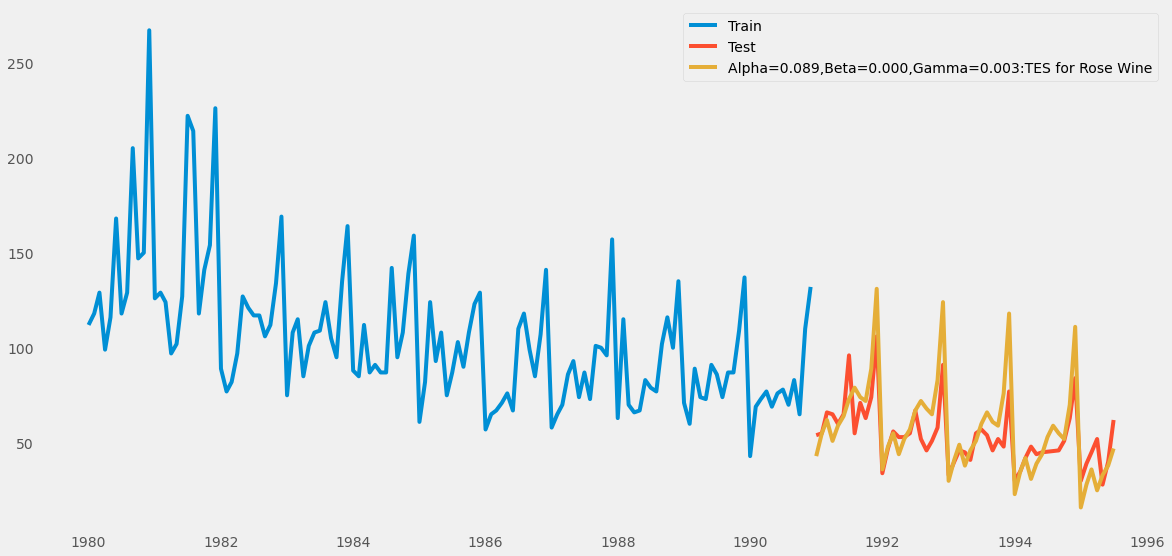

In [387]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(train_rose['Rose'], label='Train')
plt.plot(test_rose['Rose'], label='Test')

plt.plot(TES_test_rose['auto_predict'], label='Alpha=0.089,Beta=0.000,Gamma=0.003:TES for Rose Wine')


plt.legend(loc='best')
plt.grid();

In [389]:
## Test Data

rmse_model6_test_1 = rmse(TES_test_rose['Rose'],
                          TES_test_rose['auto_predict'])
print("The RMSE value of TES with Alpha = 0.089,Beta = 0.000,Gamma = 0.003 is:",rmse_model6_test_1)

The RMSE value of TES with Alpha = 0.089,Beta = 0.000,Gamma = 0.003 is: 14.2118929069987


In [390]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExponentialSmoothing-Rose Wine'])

results = pd.concat([results, resultsDf_8_1])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893

**Inference**

Triple Exponential Smoothing has performed the best on the test as expected since the data had both trend and seasonality.

But we see that our triple exponential smoothing is under forecasting. Let us try to tweak some of the parameters in order to get a better forecast on the test set.

## Triple Exponential Smoothing- Holt-Winters - ETS(A, A, M) - Holt Winter's linear method

### Rose Wine Data

In [140]:
TES_train_rose_am = train_rose.copy()
TES_test_rose_am = test_rose.copy()

In [391]:
# Initializing the Double Exponential Smoothing Model
model_TES_rose_am = ExponentialSmoothing(TES_train_rose_am['Rose'],trend='additive',seasonal='multiplicative',initialization_method='estimated')
# Fitting the model
model_TES_rose_am = model_TES_rose_am.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES_rose_am.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.0715106306609405, 'smoothing_trend': 0.04529179757535142, 'smoothing_seasonal': 7.244325029450242e-05, 'damping_trend': nan, 'initial_level': 130.40839142502193, 'initial_trend': -0.77985743179386, 'initial_seasons': array([0.86218996, 0.977675  , 1.0687727 , 0.93403881, 1.050625  ,
       1.14410977, 1.25836944, 1.33937772, 1.26778766, 1.24131254,
       1.44724625, 1.99553681]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [392]:
TES_test_rose_am['auto_predict'] = model_TES_rose_am.forecast(steps=len(test_rose)).round(0)

TES_test_rose_am.head()

Rose  auto_predict
YearMonth                     
1991-01-01  54.0          56.0
1991-02-01  55.0          64.0
1991-03-01  66.0          69.0
1991-04-01  65.0          60.0
1991-05-01  60.0          68.0

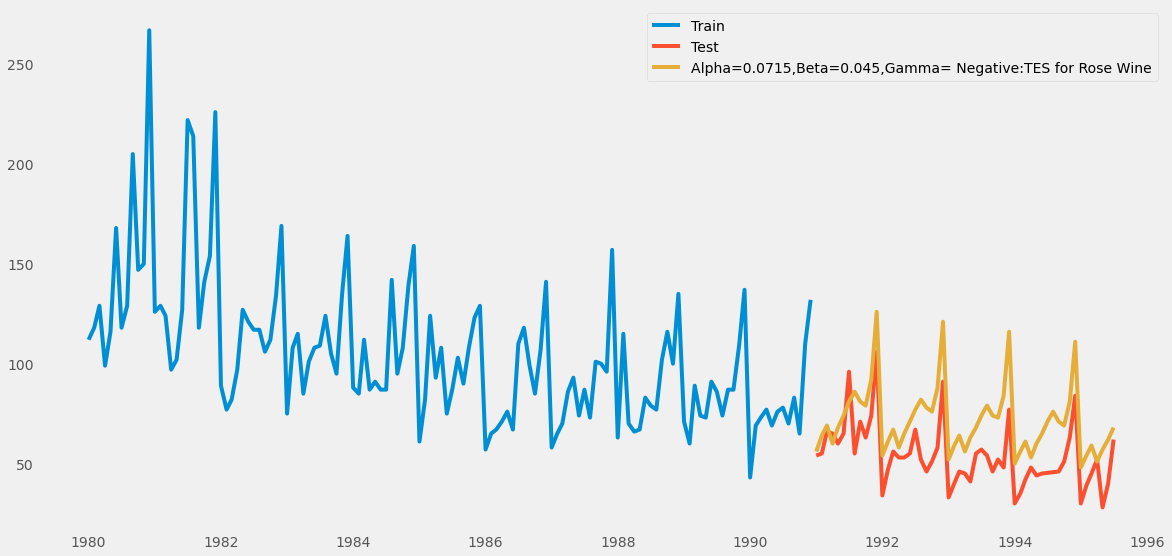

In [393]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(train_rose['Rose'], label='Train')
plt.plot(test_rose['Rose'], label='Test')

plt.plot(TES_test_rose_am['auto_predict'], label='Alpha=0.0715,Beta=0.045,Gamma= Negative:TES for Rose Wine')


plt.legend(loc='best')
plt.grid();

In [394]:
## Test Data

rmse_model6_test_am = rmse(TES_test_rose_am['Rose'],
                          TES_test_rose_am['auto_predict'])
rmse_model6_test_am

print("The RMSE value of TES with Alpha = 0.0715,Beta = 0.045,Gamma = Negative is:",rmse_model6_test_am)

The RMSE value of TES with Alpha = 0.0715,Beta = 0.045,Gamma = Negative is: 20.211816750694044


In [396]:
resultsDf_8_am = pd.DataFrame({'Test RMSE': [rmse_model6_test_am]}
                           ,index=['Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleExponentialSmoothing-Rose Wine'])

results = pd.concat([results, resultsDf_8_am])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817

**Inference**

We see that the multiplicative seasonality model has not done that well when compared to the additive seasonality Triple Exponential Smoothing model.



##  Linear Regression Model


For this particular linear regression, we are going to regress the 'Sparkling' variable against the order of the occurrence. For this we need to modify our training data before fitting it into a linear regression.

### Rose Wine data¶

In [165]:
train_time = [i+1 for i in range(len(train_rose))] # 1 to 132
test_time = [i+133 for i in range(len(test_rose))] # 133 to 187
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [399]:
LinearRegression_train_rose = train_rose.copy()
LinearRegression_test_rose = test_rose.copy()
LinearRegression_train_rose['time'] = train_time
LinearRegression_test_rose['time'] = test_time
display(LinearRegression_train_rose.head())
display(LinearRegression_test_rose.tail())

Rose  time
YearMonth              
1980-01-01  112.0     1
1980-02-01  118.0     2
1980-03-01  129.0     3
1980-04-01   99.0     4
1980-05-01  116.0     5

Rose  time
YearMonth             
1995-03-01  45.0   183
1995-04-01  52.0   184
1995-05-01  28.0   185
1995-06-01  40.0   186
1995-07-01  62.0   187

In [401]:
from sklearn.linear_model import LinearRegression
lr_rose = LinearRegression()
lr_rose.fit(LinearRegression_train_rose[['time']],LinearRegression_train_rose['Rose']) 
test_predictions_model1_rose= lr_rose.predict(LinearRegression_test_rose[['time']])
LinearRegression_test_rose['RegOnTime'] = test_predictions_model1_rose


In [402]:
rmse_model1_rose= rmse(test_rose['Rose'],test_predictions_model1_rose)
rmse_model1_rose
print("The RMSE value of Linear Regression Model is:",rmse_model1_rose )

The RMSE value of Linear Regression Model is: 15.269019701431121


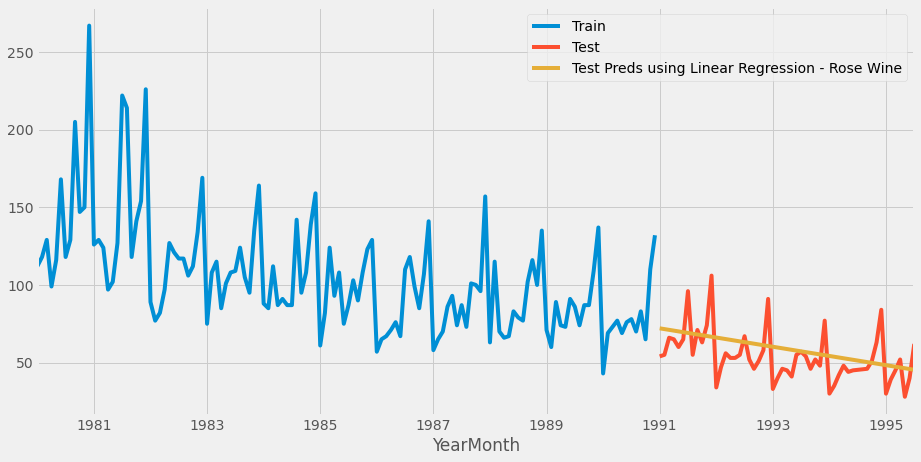

In [403]:
train_rose['Rose'].plot(legend = True, label = 'Train')
test_rose['Rose'].plot(legend = True, label = 'Test')
LinearRegression_test_rose['RegOnTime'].plot(legend = True, 
                                        label = 'Test Preds using Linear Regression - Rose Wine');

In [170]:
results_9 = pd.DataFrame({'Test RMSE': rmse_model1_rose}
                           ,index=['Linear Regression Model for Rose Wine'])

results = pd.concat([results, results_9])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine     36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine     47.817385
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing-R...  265.567837
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...   14.211893
Alpha=0.071,Beta=0.045,Gamma=0.000,TripleExpone...   20.211817
Linear Regression Model for Rose Wine                15.269020

**Inference**


## Naive Approach Model  $\hat{y}_{t+1} = y_t$


For this particular naive model, we say that the prediction for tomorrow is the same as today and the prediction for day after tomorrow is tomorrow and since the prediction of tomorrow is same as today,therefore the prediction for day after tomorrow is also today.




### Rose Wine data

In [404]:
NaiveModel_train_rose = train_rose.copy()
NaiveModel_test_rose = test_rose.copy()
NaiveModel_test_rose['naive'] = train_rose['Rose'][len(train_rose['Rose'])-1] 
# picking out the last value in train dataset

In [405]:
NaiveModel_test_rose['naive'].head()

YearMonth
1991-01-01    132.0
1991-02-01    132.0
1991-03-01    132.0
1991-04-01    132.0
1991-05-01    132.0
Name: naive, dtype: float64

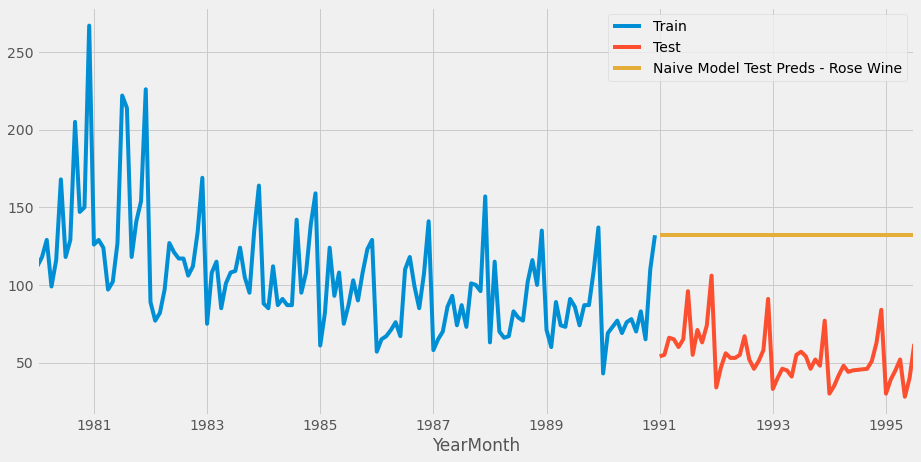

In [406]:
train_rose['Rose'].plot(legend = True, label = 'Train')
test_rose['Rose'].plot(legend = True, label = 'Test')
NaiveModel_test_rose['naive'].plot(legend = True, label = 'Naive Model Test Preds - Rose Wine');

In [407]:
rmse_model_naive_rose=rmse(test_rose['Rose'],NaiveModel_test_rose['naive'])
rmse_model_naive_rose

print("The RMSE value of Naive Model is:",rmse_model_naive_rose )

The RMSE value of Naive Model is: 79.71897053798652


In [176]:
results_11 = pd.DataFrame({'Test RMSE': rmse_model_naive_rose}
                           ,index=['Naive Model for Rose Wine'])

results = pd.concat([results, results_11])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine     36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine     47.817385
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing-R...  265.567837
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...   14.211893
Alpha=0.071,Beta=0.045,Gamma=0.000,TripleExpone...   20.211817
Linear Regression Model for Rose Wine                15.269020
Naive Model for Rose Wine                            79.718971

## Simple Average Model


For this particular simple average method, we will forecast by using the average of the training values



### Rose Wine data

In [408]:
SimpleAverage_train_rose = train_rose.copy()
SimpleAverage_test_rose = test_rose.copy()
SimpleAverage_test_rose['mean_forecast'] = train_rose['Rose'].mean()
SimpleAverage_test_rose.head()

Rose  mean_forecast
YearMonth                      
1991-01-01  54.0     104.939394
1991-02-01  55.0     104.939394
1991-03-01  66.0     104.939394
1991-04-01  65.0     104.939394
1991-05-01  60.0     104.939394

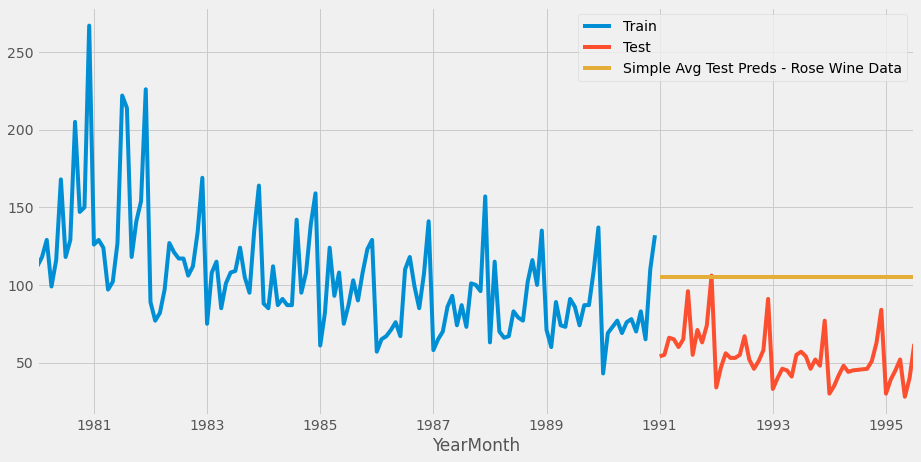

In [409]:
train_rose['Rose'].plot(legend = True, label = 'Train')
test_rose['Rose'].plot(legend = True, label = 'Test')
SimpleAverage_test_rose['mean_forecast'].plot(legend=True,label= 'Simple Avg Test Preds - Rose Wine Data');

In [410]:
## Test Data - RMSE 

rmse_model_sa_rose = rmse(test_rose['Rose'], SimpleAverage_test_rose['mean_forecast'])
rmse_model_sa_rose

print("The RMSE value of Simple Average Model is:",rmse_model_sa_rose )

The RMSE value of Simple Average Model is: 53.46077161826419


In [180]:
results_13 = pd.DataFrame({'Test RMSE': rmse_model_sa_rose}
                           ,index=['Simple Average Model for Rose Wine'])

results = pd.concat([results, results_13])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine     36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine     47.817385
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing-R...  265.567837
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...   14.211893
Alpha=0.071,Beta=0.045,Gamma=0.000,TripleExpone...   20.211817
Linear Regression Model for Rose Wine                15.269020
Naive Model for Rose Wine                            79.718971
Simple Average Model for Rose Wine                   53.460772

## Moving Average(MA) Model

For the moving average model, we are going to calculate rolling means (or moving averages) for different intervals. The best interval can be determined by the maximum accuracy (or the minimum error) over here.


*For Moving Average, we are going to average over the entire data.*


### Rose Wine Data

In [518]:
MovingAverage_rose = df_wine_rose.copy()
MovingAverage_rose.head()

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

**Trailing moving averages**

In [519]:
MovingAverage_rose['Trailing_2'] = MovingAverage_rose['Rose'].rolling(2).mean()
MovingAverage_rose['Trailing_4'] = MovingAverage_rose['Rose'].rolling(4).mean()
MovingAverage_rose['Trailing_6'] = MovingAverage_rose['Rose'].rolling(6).mean()
MovingAverage_rose['Trailing_9'] = MovingAverage_rose['Rose'].rolling(9).mean()

MovingAverage_rose.head(10)

Rose  Trailing_2  Trailing_4  Trailing_6  Trailing_9
YearMonth                                                        
1980-01-01  112.0         NaN         NaN         NaN         NaN
1980-02-01  118.0       115.0         NaN         NaN         NaN
1980-03-01  129.0       123.5         NaN         NaN         NaN
1980-04-01   99.0       114.0      114.50         NaN         NaN
1980-05-01  116.0       107.5      115.50         NaN         NaN
1980-06-01  168.0       142.0      128.00  123.666667         NaN
1980-07-01  118.0       143.0      125.25  124.666667         NaN
1980-08-01  129.0       123.5      132.75  126.500000         NaN
1980-09-01  205.0       167.0      155.00  139.166667  132.666667
1980-10-01  147.0       176.0      149.75  147.166667  136.555556

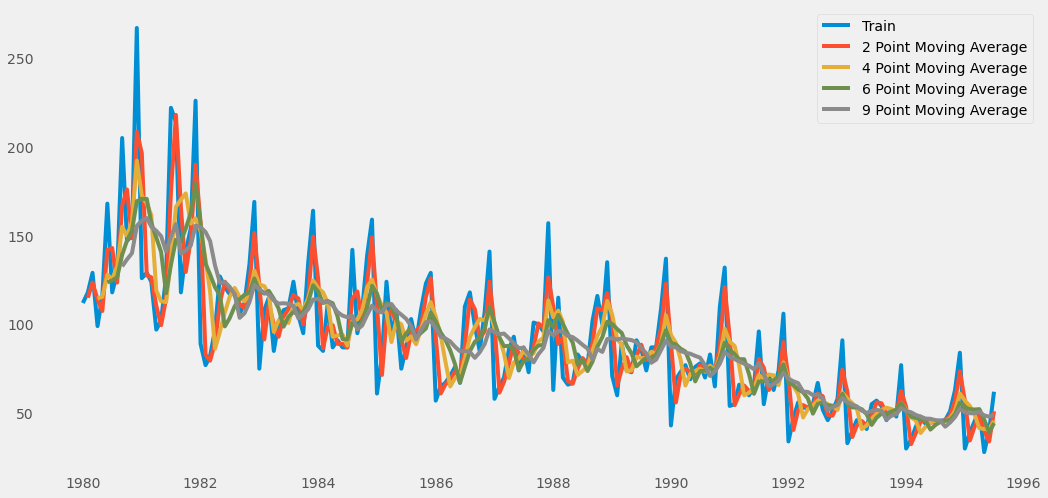

In [520]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(MovingAverage_rose['Rose'], label='Train')
plt.plot(MovingAverage_rose['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage_rose['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage_rose['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage_rose['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

**Let us split the data into train and test and plot this Time Series**

In [521]:
#Creating train and test set 
trailing_MovingAverage_train_rose=MovingAverage_rose[0:132] 
trailing_MovingAverage_test_rose=MovingAverage_rose[132:]

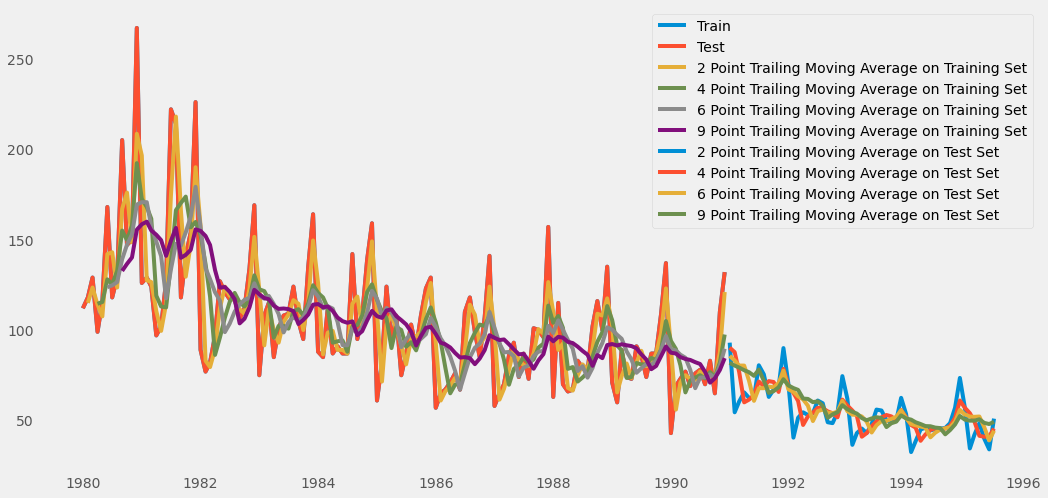

In [522]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train_rose['Rose'], label='Train')
plt.plot(trailing_MovingAverage_train_rose['Rose'], label='Test')

plt.plot(trailing_MovingAverage_train_rose['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_rose['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_rose['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_rose['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test_rose['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_rose['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_rose['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_rose['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

**Model Evaluation**

In [523]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model_ma_rose_test_2 = rmse(test_rose['Rose'],trailing_MovingAverage_test_rose['Trailing_2'])

print("The RMSE value of 2 point Trailing MA Model is :",rmse_model_ma_rose_test_2)
## Test Data - RMSE  --> 4 point Trailing MA

rmse_model_ma_rose_test_4 = rmse(test_rose['Rose'],trailing_MovingAverage_test_rose['Trailing_4'])

print("The RMSE value of 4 point Trailing MA Model is :",rmse_model_ma_rose_test_4)
## Test Data - RMSE --> 6 point Trailing MA

rmse_model_ma_rose_test_6 = rmse(test_rose['Rose'],trailing_MovingAverage_test_rose['Trailing_6'])

print("The RMSE value of 6 point Trailing MA Model is :",rmse_model_ma_rose_test_6)


## Test Data - RMSE  --> 9 point Trailing MA

rmse_model_ma_rose_test_9 = rmse(test_rose['Rose'],trailing_MovingAverage_test_rose['Trailing_9'])

print("The RMSE value of 9 point Trailing MA Model is :",rmse_model_ma_rose_test_9)

The RMSE value of 2 point Trailing MA Model is : 11.529277632500344
The RMSE value of 4 point Trailing MA Model is : 14.451438997238617
The RMSE value of 6 point Trailing MA Model is : 14.566381305713316
The RMSE value of 9 point Trailing MA Model is : 14.727662638005398


In [417]:
results_15 = pd.DataFrame({'Test RMSE': [rmse_model_ma_rose_test_2, 
                                          rmse_model_ma_rose_test_4,
                                          rmse_model_ma_rose_test_6, 
                                          rmse_model_ma_rose_test_9]}, 
                           index=['2 pointTrailingMovingAverage-Rose Wine',
                                  '4 pointTrailingMovingAverage-Rose Wine', 
                                  '6 pointTrailingMovingAverage-Rose Wine',
                                  '9 pointTrailingMovingAverage-Rose Wine'])

results = pd.concat([results, results_15])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
2 pointTrailingMovingAverage-Rose Wine              11.529278
4 pointTrailingMovingAverage-Rose Wine              14.451439
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663

We can see that 2 point Moving Average Model works better compared to SES, DES, TES and other models.

### 5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

**Check for stationarity of the whole Time Series data.**

**Dicky Fuller Test**

* Null Hypothesis H0- Series is not Stationary
* Alternative Hypothesis H1- Series is Stationary

In [391]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller 

In [188]:
## Test for stationarity of the series - Dicky Fuller test

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False) ## You plot will stay open - will be seen always
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test for Rose Wine Data:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')    


### Rose Wine data

## i) Test for Stationarity on whole data

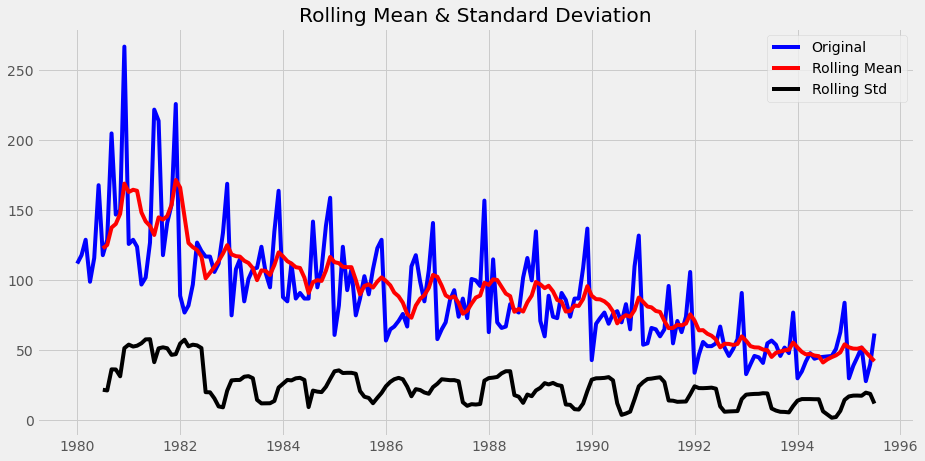

Results of Dickey-Fuller Test for Rose Wine Data:
Test Statistic                  -1.876681
p-value                          0.343109
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 



In [418]:
test_stationarity(df_wine_rose['Rose'])

**Inference**

* We can see that the pvalue is greater than 0.05. Thus we cannot reject the Null hypothesis and hence Rose Wine data is not stationary.
* We see that at 5% significant level the Time Series is non-stationary.

Let us take a difference of order 1 and check whether the Time Series is stationary or not.

### Taking Diffrence to make the Data Stationary


### d=1

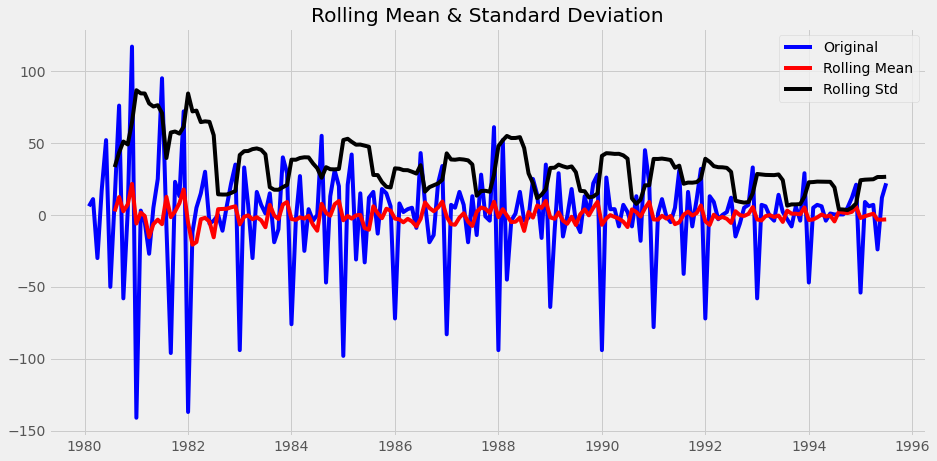

Results of Dickey-Fuller Test for Rose Wine Data:
Test Statistic                -8.044390e+00
p-value                        1.810919e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64 



In [419]:
test_stationarity(df_wine_rose['Rose'].diff().dropna())

We see that at  𝛼 = 0.05 the Time Series is indeed stationary as the p-value is lower than 0.05 and hence we can reject the null hypothesis which says that the time series is not stationary. So differentiation by 1 makes the time series stationary.

## ii) Test for Stationarity on Train and Test data

In [420]:
adfuller(train_rose['Rose'])[1]
print("The Dicky Fuller Test value for Train dataset is: ",adfuller(train_rose['Rose'])[1] )

The Dicky Fuller Test value for Train dataset is:  0.21947564129072272


We see that the series is not stationary at 𝛼 = 0.05.

In [421]:
adfuller(train_rose['Rose'].diff().dropna())[1]

print("The Dicky Fuller Test value for Train dataset after differencing (d=1) is: ",adfuller(train_rose['Rose'].diff().dropna())[1])

The Dicky Fuller Test value for Train dataset after differencing (d=1) is:  7.061943750943758e-09


We can see that after taking a difference of order 1 the series have become stationary at 𝛼 = 0.05.


**Inference**

•	We see that at 𝛼 = 0.05 the Time Series is indeed stationary as the p-value is lower than 0.05 and hence we can reject the null hypothesis which says that the time series is not stationary. So differentiation by 1 makes the time series stationary.

•	This test is not done for Test data as we are not building any models on the Test Data. We shall only evaluate our models on Test data.

•	If the time series is not stationary even after first differentiation, then we need to repeat the process of differencing. (d=2,3,4,5..)


### 6. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

The data has some seasonality so ideally we should build a SARIMA model. Thus we are are building an ARIMA /SARIMA model both automatically, by looking at the minimum AIC criterion and manually, by looking at the ACF and the PACF plots

## ARIMA MODEL

In [193]:
from statsmodels.tsa.arima.model import ARIMA # statsmodels.tsa.arima_model

In [194]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 1 as we already know that we need to take a first order difference of the series to make it stationary.

import itertools # library for generating all possible combinations of given number sets
p = q = range(0, 4)
d= range(1,2) # required as itertools product function expects the parameters as range objects, even if it is only value

pdq = list(itertools.product(p, d, q))

print('Some parameter combinations for the Model...')
for i in range(0,len(pdq)):
    print(f'Model: {pdq[i]}')

Some parameter combinations for the Model...
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [195]:
# Creating an empty Dataframe with column names only
ARIMA_AIC_Rose = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC_Rose

Empty DataFrame
Columns: [param, AIC]
Index: []

In [196]:
for param in pdq:
    ARIMA_model_rose = ARIMA(train_rose['Rose'],
                        order=param).fit()
    
    print(f'ARIMA{param} - AIC:{ARIMA_model_rose.aic}')
    
    ARIMA_AIC_Rose=ARIMA_AIC_Rose.append({'param':param, 
                                'AIC': ARIMA_model_rose.aic},
                               ignore_index=True)

ARIMA(0, 1, 0) - AIC:1333.1546729124348
ARIMA(0, 1, 1) - AIC:1282.3098319748322
ARIMA(0, 1, 2) - AIC:1279.6715288535772
ARIMA(0, 1, 3) - AIC:1280.5453761734657
ARIMA(1, 1, 0) - AIC:1317.3503105381506
ARIMA(1, 1, 1) - AIC:1280.5742295380041
ARIMA(1, 1, 2) - AIC:1279.870723423191
ARIMA(1, 1, 3) - AIC:1281.8707223309964
ARIMA(2, 1, 0) - AIC:1298.6110341604945
ARIMA(2, 1, 1) - AIC:1281.507862186853
ARIMA(2, 1, 2) - AIC:1281.870722226428
ARIMA(2, 1, 3) - AIC:1274.695133266559
ARIMA(3, 1, 0) - AIC:1297.481091727172
ARIMA(3, 1, 1) - AIC:1282.4192776271973
ARIMA(3, 1, 2) - AIC:1283.720740597714
ARIMA(3, 1, 3) - AIC:1278.6586164596035


In [422]:
ARIMA_AIC_Rose

param          AIC
0   (0, 1, 0)  1333.154673
1   (0, 1, 1)  1282.309832
2   (0, 1, 2)  1279.671529
3   (0, 1, 3)  1280.545376
4   (1, 1, 0)  1317.350311
5   (1, 1, 1)   1280.57423
6   (1, 1, 2)  1279.870723
7   (1, 1, 3)  1281.870722
8   (2, 1, 0)  1298.611034
9   (2, 1, 1)  1281.507862
10  (2, 1, 2)  1281.870722
11  (2, 1, 3)  1274.695133
12  (3, 1, 0)  1297.481092
13  (3, 1, 1)  1282.419278
14  (3, 1, 2)  1283.720741
15  (3, 1, 3)  1278.658616

In [198]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC_Rose.sort_values(by='AIC',ascending=True)

param          AIC
11  (2, 1, 3)  1274.695133
15  (3, 1, 3)  1278.658616
2   (0, 1, 2)  1279.671529
6   (1, 1, 2)  1279.870723
3   (0, 1, 3)  1280.545376
5   (1, 1, 1)   1280.57423
9   (2, 1, 1)  1281.507862
10  (2, 1, 2)  1281.870722
7   (1, 1, 3)  1281.870722
1   (0, 1, 1)  1282.309832
13  (3, 1, 1)  1282.419278
14  (3, 1, 2)  1283.720741
12  (3, 1, 0)  1297.481092
8   (2, 1, 0)  1298.611034
4   (1, 1, 0)  1317.350311
0   (0, 1, 0)  1333.154673

In [199]:
auto_ARIMA_rose = ARIMA(train_rose['Rose'], order=(2,1,3))

results_auto_ARIMA = auto_ARIMA_rose.fit()

results_auto_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -631.348
Date:                Fri, 10 Mar 2023   AIC                           1274.695
Time:                        19:49:56   BIC                           1291.946
Sample:                    01-01-1980   HQIC                          1281.705
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6779      0.084    -20.050      0.000      -1.842      -1.514
ar.L2         -0.7289      0.084     -8.711      0.000      -0.893      -0.565
ma.L1          1.0448      0.662      1.578      0.115      -0.253       2.343
ma.L2         -0.7718      0.135     -5.718      0.000      -1.036      -0.507
ma.L3         -0.9047      0.601     -1.505      0.132      -2.083       0.273
sigma2       858.1608    557.360      1.540      0.124    -234.245    1950.567
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                24.45
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict on the Test Set using this model and evaluate the model.

In [201]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test_rose))

In [202]:
predicted_auto_ARIMA

1991-01-01    85.624481
1991-02-01    90.524657
1991-03-01    81.975627
1991-04-01    92.748894
1991-05-01    80.902980
1991-06-01    92.927580
1991-07-01    81.384964
1991-08-01    91.988600
1991-09-01    82.609222
1991-10-01    90.618747
1991-11-01    84.015450
1991-12-01    89.257603
1992-01-01    85.274431
1992-02-01    88.137183
1992-03-01    86.236814
1992-04-01    87.338986
1992-05-01    86.874704
1992-06-01    86.850415
1992-07-01    87.229567
1992-08-01    86.611074
1992-09-01    87.372523
1992-10-01    86.545648
1992-11-01    87.378110
1992-12-01    86.583960
1993-01-01    87.309753
1993-02-01    86.670736
1993-03-01    87.213970
1993-04-01    86.768206
1993-05-01    87.120233
1993-06-01    86.854450
1993-07-01    87.043840
1993-08-01    86.919772
1993-09-01    86.989913
1993-10-01    86.962649
1993-11-01    86.957274
1993-12-01    86.986165
1994-01-01    86.941605
1994-02-01    86.995316
1994-03-01    86.937670
1994-04-01    86.995250
1994-05-01    86.940650
1994-06-01    86

In [424]:
# from sklearn.metrics import  mean_squared_error --> alternate method
from statsmodels.tools.eval_measures import rmse

# predicted_auto_ARIMA[0] contains the predictions(mean values)
RMSE_autoarima = rmse(test_rose['Rose'],predicted_auto_ARIMA[0])

print("The RMSE value of ARIMA (2,1,3) is:",RMSE_autoarima )

The RMSE value of ARIMA (2,1,3) is: 35.464266059758025


In [457]:
results_12 = pd.DataFrame({'Test RMSE': [RMSE_autoarima]}
                           ,index=['ARIMA(2,1,3)'])
results = pd.concat([results, results_12])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
2 pointTrailingMovingAverage-Rose Wine              11.529278
4 pointTrailingMovingAverage-Rose Wine              14.451439
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663
ARIMA(2,1,3)                                        35.464266

### Automated version of a SARIMA model -Parameter Selection with lowest Akaike Information Criteria (AIC).

Let us look at the ACF plot once more to understand the seasonal parameters PDQ for the SARIMA model.

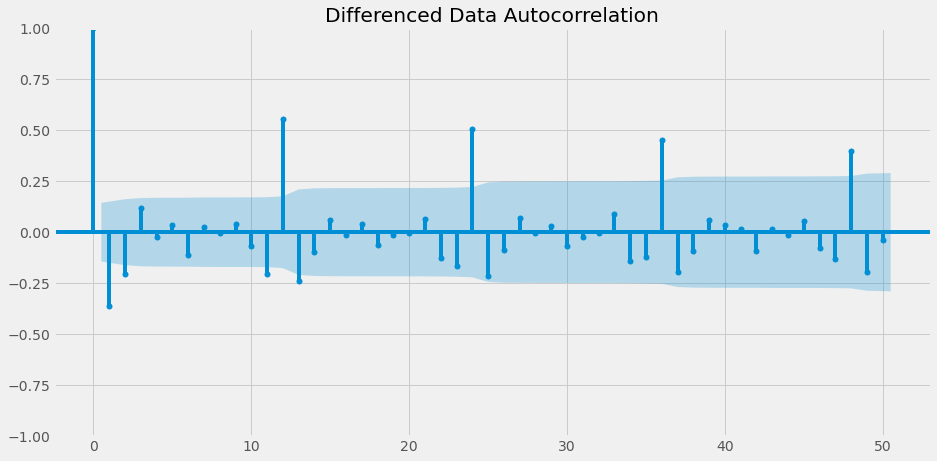

In [426]:
plot_acf(df_wine_rose['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation');

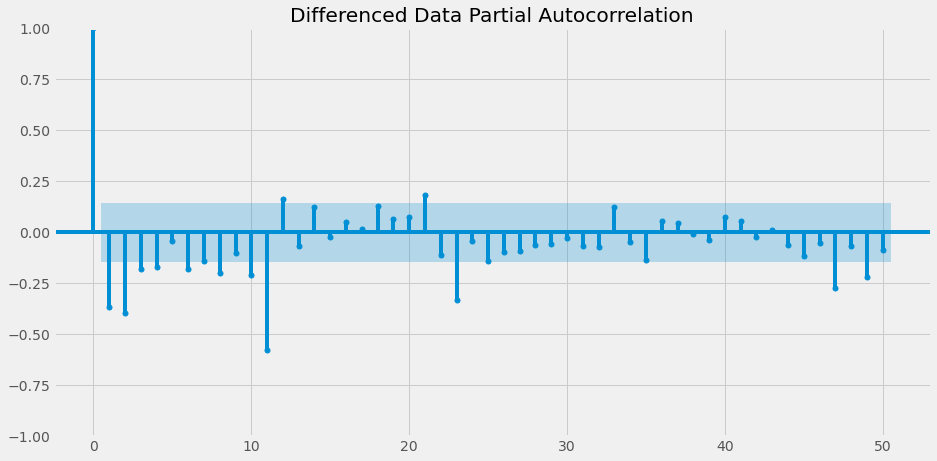

In [427]:
plot_pacf(df_wine_rose['Rose'].diff().dropna(),lags=50,
          title='Differenced Data Partial Autocorrelation');

We see that there can be a seasonality of 6 as well as 12. We will run our auto SARIMA models by setting seasonality both as 6 and 12.


Here, we have taken alpha=0.05.

 * The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 4.
 * The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.


### Auto SARIMA model - With Seasonality as 6

In [429]:
import itertools
p = q = range(0, 4)
d= range(1,2)
D = range(1,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, D, q))] # seasonal PDQ
print('Examples of some parameter combinations for Model...')
for i in range(0,len(pdq)):
    print(f'Model: {pdq[i]}{model_pdq[i]}')

Examples of some parameter combinations for Model...
Model: (0, 1, 0)(0, 1, 0, 6)
Model: (0, 1, 1)(0, 1, 1, 6)
Model: (0, 1, 2)(0, 1, 2, 6)
Model: (0, 1, 3)(0, 1, 3, 6)
Model: (1, 1, 0)(1, 1, 0, 6)
Model: (1, 1, 1)(1, 1, 1, 6)
Model: (1, 1, 2)(1, 1, 2, 6)
Model: (1, 1, 3)(1, 1, 3, 6)
Model: (2, 1, 0)(2, 1, 0, 6)
Model: (2, 1, 1)(2, 1, 1, 6)
Model: (2, 1, 2)(2, 1, 2, 6)
Model: (2, 1, 3)(2, 1, 3, 6)
Model: (3, 1, 0)(3, 1, 0, 6)
Model: (3, 1, 1)(3, 1, 1, 6)
Model: (3, 1, 2)(3, 1, 2, 6)
Model: (3, 1, 3)(3, 1, 3, 6)


In [430]:
SARIMA_AIC_1 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC_1

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [431]:
from  statsmodels.tsa.statespace.sarimax import SARIMAX

# import statsmodels.api as sm
# sm.tsa.statespace.SARIMAX()

In [432]:
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model_1 = SARIMAX(train_rose['Rose'],order=param, 
                               seasonal_order = param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
            
        results_SARIMA_1 = SARIMA_model_1.fit(maxiter=1000)
        
        print(f'SARIMA{param}x{param_seasonal} - AIC:{results_SARIMA_1.aic}')
        
        SARIMA_AIC_1 = SARIMA_AIC_1.append({'param':param,
                                        'seasonal':param_seasonal, 
                                        'AIC': results_SARIMA_1.aic},
                                       ignore_index=True)

SARIMA(0, 1, 0)x(0, 1, 0, 6) - AIC:1362.6525264440118
SARIMA(0, 1, 0)x(0, 1, 1, 6) - AIC:1185.4374421231378
SARIMA(0, 1, 0)x(0, 1, 2, 6) - AIC:1085.222176554221
SARIMA(0, 1, 0)x(0, 1, 3, 6) - AIC:990.5887854028596
SARIMA(0, 1, 0)x(1, 1, 0, 6) - AIC:1170.9535453581327
SARIMA(0, 1, 0)x(1, 1, 1, 6) - AIC:1159.573305562745
SARIMA(0, 1, 0)x(1, 1, 2, 6) - AIC:1055.7799642018786
SARIMA(0, 1, 0)x(1, 1, 3, 6) - AIC:966.9177276449516
SARIMA(0, 1, 0)x(2, 1, 0, 6) - AIC:1087.964541625571
SARIMA(0, 1, 0)x(2, 1, 1, 6) - AIC:1063.3058015292956
SARIMA(0, 1, 0)x(2, 1, 2, 6) - AIC:1057.8948379464712
SARIMA(0, 1, 0)x(2, 1, 3, 6) - AIC:967.4811853003431
SARIMA(0, 1, 0)x(3, 1, 0, 6) - AIC:972.6644364360184
SARIMA(0, 1, 0)x(3, 1, 1, 6) - AIC:972.6264651826996
SARIMA(0, 1, 0)x(3, 1, 2, 6) - AIC:974.6258997939453
SARIMA(0, 1, 0)x(3, 1, 3, 6) - AIC:965.5753080822753
SARIMA(0, 1, 1)x(0, 1, 0, 6) - AIC:1305.2519512333376
SARIMA(0, 1, 1)x(0, 1, 1, 6) - AIC:1133.3738796962716
SARIMA(0, 1, 1)x(0, 1, 2, 6) - AIC:102

SARIMA(2, 1, 1)x(2, 1, 2, 6) - AIC:968.5764368916821
SARIMA(2, 1, 1)x(2, 1, 3, 6) - AIC:924.3635463018655
SARIMA(2, 1, 1)x(3, 1, 0, 6) - AIC:914.9052789001069
SARIMA(2, 1, 1)x(3, 1, 1, 6) - AIC:916.8748001712794
SARIMA(2, 1, 1)x(3, 1, 2, 6) - AIC:922.6244082359086
SARIMA(2, 1, 1)x(3, 1, 3, 6) - AIC:926.3192128733898
SARIMA(2, 1, 2)x(0, 1, 0, 6) - AIC:1278.7390386816505
SARIMA(2, 1, 2)x(0, 1, 1, 6) - AIC:1116.9299065837213
SARIMA(2, 1, 2)x(0, 1, 2, 6) - AIC:1011.1384015990369
SARIMA(2, 1, 2)x(0, 1, 3, 6) - AIC:933.2544112625471
SARIMA(2, 1, 2)x(1, 1, 0, 6) - AIC:1094.6959809183961
SARIMA(2, 1, 2)x(1, 1, 1, 6) - AIC:1084.4938567043118
SARIMA(2, 1, 2)x(1, 1, 2, 6) - AIC:957.8063009339178
SARIMA(2, 1, 2)x(1, 1, 3, 6) - AIC:926.5875885337806
SARIMA(2, 1, 2)x(2, 1, 0, 6) - AIC:994.9724169538783
SARIMA(2, 1, 2)x(2, 1, 1, 6) - AIC:1004.9746002741094
SARIMA(2, 1, 2)x(2, 1, 2, 6) - AIC:959.8061480122838
SARIMA(2, 1, 2)x(2, 1, 3, 6) - AIC:927.8248591244433
SARIMA(2, 1, 2)x(3, 1, 0, 6) - AIC:916.6

In [434]:
SARIMA_AIC_1.sort_values(by=['AIC']).head()

param      seasonal         AIC
187  (2, 1, 3)  (2, 1, 3, 6)  889.189506
251  (3, 1, 3)  (2, 1, 3, 6)  891.125829
255  (3, 1, 3)  (3, 1, 3, 6)  893.125643
183  (2, 1, 3)  (1, 1, 3, 6)  894.757072
63   (0, 1, 3)  (3, 1, 3, 6)  894.905696

In [435]:
import statsmodels.api as sm

auto_SARIMA_1 = sm.tsa.statespace.SARIMAX(train_rose['Rose'].values,
                                order=(2, 1, 3),
                                seasonal_order=(2, 1, 3, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA_1 = auto_SARIMA_1.fit(maxiter=1000)
print(results_auto_SARIMA_1.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  132
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 6)   Log Likelihood                -433.595
Date:                           Sun, 12 Mar 2023   AIC                            889.190
Time:                                   12:23:25   BIC                            918.172
Sample:                                        0   HQIC                           900.928
                                           - 132                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5746      0.023     25.069      0.000       0.530       0.620
ar.L2         -0.9163      0.021    -43.489

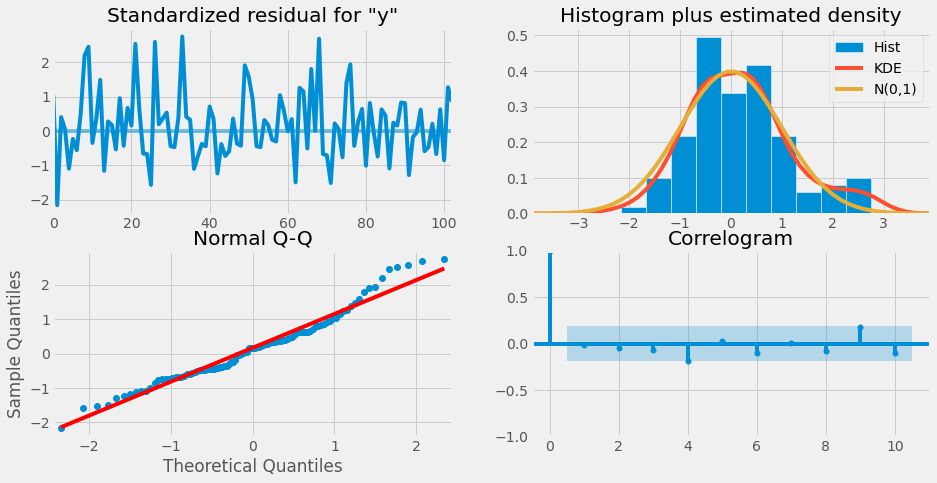

In [436]:
results_auto_SARIMA_1.plot_diagnostics()
plt.show()

From the model diagnostics plot, we can see that all the individual diagnostics plots almost follow the theoretical numbers and thus we cannot develop any pattern from these plots.

### Predict on the Test Set using this model and evaluate the model.

In [437]:
predicted_auto_SARIMA_1 = results_auto_SARIMA_1.get_forecast(steps=len(test_rose))
predicted_auto_SARIMA_1.summary_frame(alpha=0.05).head()

y       mean    mean_se  mean_ci_lower  mean_ci_upper
0  54.884227  15.044529      25.397492      84.370961
1  63.974575  15.156761      34.267870      93.681281
2  71.841245  15.454176      41.551616     102.130874
3  69.051787  15.806599      38.071421     100.032152
4  77.045897  15.992199      45.701764     108.390031

In [438]:
predicted_auto_SARIMA_1.predicted_mean

array([ 54.88422653,  63.97457536,  71.84124512,  69.05178667,
        77.04589706,  80.30149192,  68.5461642 ,  77.16499355,
        76.50215916,  76.50031562,  87.72391691, 113.13074696,
        51.72826345,  60.72727068,  67.39001692,  62.80114624,
        72.41947473,  78.61791242,  63.99191037,  71.02250493,
        70.16690442,  70.24198461,  83.07209343, 107.6651711 ,
        47.44913993,  55.40687464,  62.44597432,  59.00235986,
        69.08356749,  75.39738417,  57.56882189,  65.05976475,
        65.58323219,  65.4270054 ,  77.46557304, 100.61940515,
        43.04948286,  51.60696476,  58.35403176,  54.44259939,
        64.33197074,  71.91871695,  52.42759809,  59.93370929,
        60.33226029,  59.69085999,  71.940424  ,  94.66673189,
        39.10335819,  47.19401792,  53.41893855,  49.92947213,
        60.28444612,  68.64535863,  46.8670561 ])

In [439]:
rmse = mean_squared_error(test_rose['Rose'],predicted_auto_SARIMA_1.predicted_mean,squared=False)

print("The RMSE value of SARIMA(2,1,3)(2,1,3,6) Model is:",rmse )

The RMSE value of SARIMA(2,1,3)(2,1,3,6) Model is: 16.74246817327473


In [250]:
from statsmodels.tools.eval_measures import rmse

In [251]:
rmse_autosarima6 =rmse(test_rose['Rose'],predicted_auto_SARIMA_6.predicted_mean)
print(rmse_autosarima6)

16.74246817327473


In [458]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse]}
                           ,index=['SARIMA(2,1,3)(2,1,3,6)'])

results = pd.concat([results, temp_resultsDf])
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
2 pointTrailingMovingAverage-Rose Wine              11.529278
4 pointTrailingMovingAverage-Rose Wine              14.451439
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663
ARIMA(2,1,3)                                        35.464266
SARIMA(2,1,3)(2,1,3,6)                              16.742468

### Setting the seasonality as 12 for the second iteration of the auto SARIMA model.

In [459]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(1,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print(f'Model: {pdq[i]}{model_pdq[i]}')

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 1, 1, 12)
Model: (0, 1, 2)(0, 1, 2, 12)
Model: (1, 1, 0)(1, 1, 0, 12)
Model: (1, 1, 1)(1, 1, 1, 12)
Model: (1, 1, 2)(1, 1, 2, 12)
Model: (2, 1, 0)(2, 1, 0, 12)
Model: (2, 1, 1)(2, 1, 1, 12)
Model: (2, 1, 2)(2, 1, 2, 12)


In [461]:
SARIMA_AIC_2 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC_2

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [462]:

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model_2 =SARIMAX(train_rose['Rose'],
                                            order=param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA_2 = SARIMA_model_2.fit(maxiter=1000)
        
        print(f'SARIMA{param}x{param_seasonal} - AIC:{results_SARIMA_2.aic}')
        
        SARIMA_AIC_2 = SARIMA_AIC_2.append({'param':param,
                                        'seasonal':param_seasonal ,
                                        'AIC': results_SARIMA_2.aic},
                                       ignore_index=True)

SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1171.2013438278946
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:965.5057301624336
SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC:845.8687014775993
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:982.3269589658806
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:975.3375383601649
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:847.7332182654516
SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:858.5132698374418
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:853.3390729144738
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:842.6282244224884
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1113.7663133562694
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:915.0730606718114
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC:790.9032809265697
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:944.2456655533291
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:929.3362488520096
SARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC:792.7161670330378
SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:810.3194350158681
SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:804.1555753770979
SARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC:782.1538715451783
SARIMA(0, 1, 2)x(0, 1, 0, 

In [463]:
SARIMA_AIC.sort_values(by=['AIC']).head()

param       seasonal         AIC
26  (0, 1, 2)  (2, 1, 2, 12)  774.969119
53  (1, 1, 2)  (2, 1, 2, 12)  776.940107
80  (2, 1, 2)  (2, 1, 2, 12)    776.9961
17  (0, 1, 1)  (2, 1, 2, 12)  782.153872
79  (2, 1, 2)  (2, 1, 1, 12)  783.703652

In [464]:
auto_SARIMA_2 =SARIMAX(train_rose['Rose'],
                                order=(0, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_auto_SARIMA_2 = auto_SARIMA_2.fit(maxiter=1000)

results_auto_SARIMA_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Rose   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -380.485
Date:                            Sun, 12 Mar 2023   AIC                            774.969
Time:                                    12:51:55   BIC                            792.622
Sample:                                01-01-1980   HQIC                           782.094
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9524      0.184     -5.167      0.000      -1.314      -0.591
ma.L2         -0.0764      0.126     -0.605      0.545      -0.324       0.171
ar.S.L12       0.0480      0.177      0.271      0.786      -0.299       0.395
ar.S.L24      -0.0419      0.028     -1.513      0.130      -0.096       0.012
ma.S.L12      -0.7525      0.301     -2.503      0.012      -1.342      -0.163
ma.S.L24      -0.0721      0.204     -0.354      0.723      -0.472       0.327
sigma2       187.8645     45.271      4.150      0.000      99.135     276.594
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.86
Prob(Q):                              0.81   Prob(JB):                         0.09
Heteroskedasticity (H):               0.91   Skew:                             0.41
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

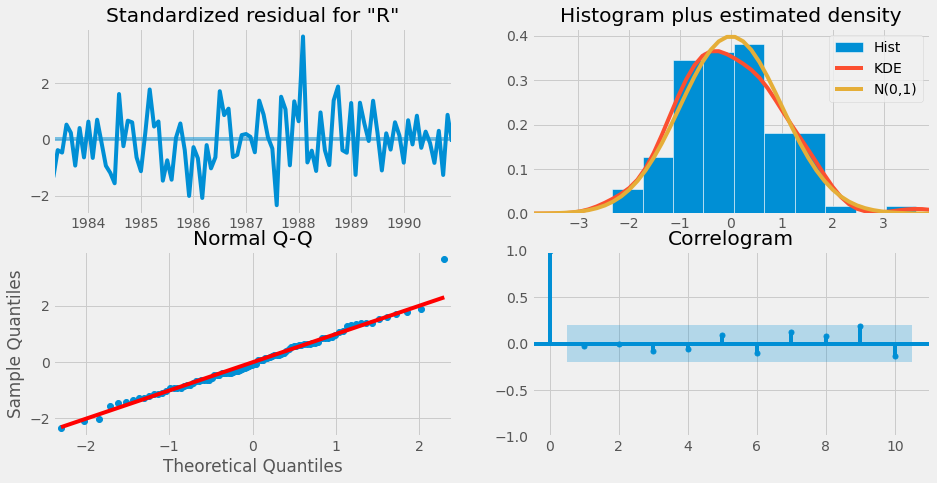

In [465]:
results_auto_SARIMA_2.plot_diagnostics()
plt.show()

### Predict on the Test Set & Evaluation

In [466]:
predicted_auto_SARIMA_2 = results_auto_SARIMA_2.get_forecast(steps=len(test_rose))
predicted_auto_SARIMA_2.summary_frame(alpha=0.05).head()

Rose             mean    mean_se  mean_ci_lower  mean_ci_upper
1991-01-01  44.213974  14.221730      16.339895      72.088053
1991-02-01  62.327327  14.300524      34.298816      90.355838
1991-03-01  67.313607  14.302433      39.281353      95.345861
1991-04-01  63.161552  14.305343      35.123596      91.199508
1991-05-01  66.474324  14.310720      38.425828      94.522820

In [467]:
predicted_auto_SARIMA_2.predicted_mean

1991-01-01     44.213974
1991-02-01     62.327327
1991-03-01     67.313607
1991-04-01     63.161552
1991-05-01     66.474324
1991-06-01     66.383578
1991-07-01     73.463957
1991-08-01     75.271564
1991-09-01     76.457103
1991-10-01     74.178549
1991-11-01     96.968322
1991-12-01    127.455888
1992-01-01     42.088455
1992-02-01     56.790674
1992-03-01     63.603746
1992-04-01     57.302740
1992-05-01     62.498142
1992-06-01     62.039733
1992-07-01     69.427985
1992-08-01     72.284548
1992-09-01     71.834998
1992-10-01     72.554088
1992-11-01     91.318591
1992-12-01    123.242567
1993-01-01     37.717414
1993-02-01     52.580065
1993-03-01     59.439465
1993-04-01     53.376730
1993-05-01     58.188738
1993-06-01     58.009603
1993-07-01     65.199892
1993-08-01     67.696097
1993-09-01     67.662824
1993-10-01     67.867399
1993-11-01     87.368829
1993-12-01    119.006306
1994-01-01     33.372313
1994-02-01     48.385494
1994-03-01     55.170624
1994-04-01     49.209301


In [469]:
from statsmodels.tools.eval_measures import rmse

In [471]:
rmse_autosarima12 = rmse(test_rose['Rose'],
                         predicted_auto_SARIMA_2.predicted_mean)

print("The RMSE value of SARIMA(0,1,2)(2,1,2,12) Model is:",rmse_autosarima12 )

The RMSE value of SARIMA(0,1,2)(2,1,2,12) Model is: 16.500546019879703


In [472]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse_autosarima12]}
                           ,index=['SARIMA(0,1,2)(2,1,2,12)'])


results = pd.concat([results,temp_resultsDf])

results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
2 pointTrailingMovingAverage-Rose Wine              11.529278
4 pointTrailingMovingAverage-Rose Wine              14.451439
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663
ARIMA(2,1,3)                                        35.464266
SARIMA(2,1,3)(2,1,3,6)                              16.742468
SARIMA(0,1,2)(2,1,2,12)                             16.500546

We can see that RMSE value of SARIMA (0,1,2) (2,1,2,12) Model is better compared to ARIMA model and SARIMA with seasonality 6.

### 7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.

### Manual ARIMA model - Using ACF & PACF plots

Let us look at the ACF and the PACF plots once more.

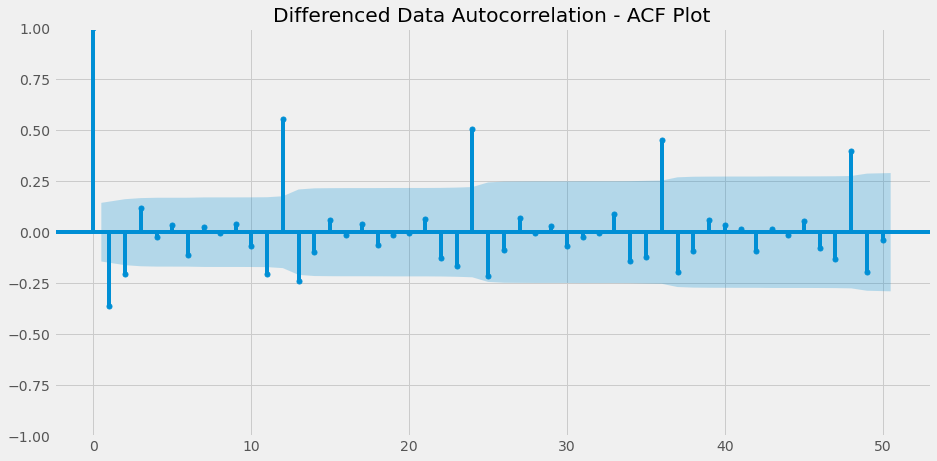

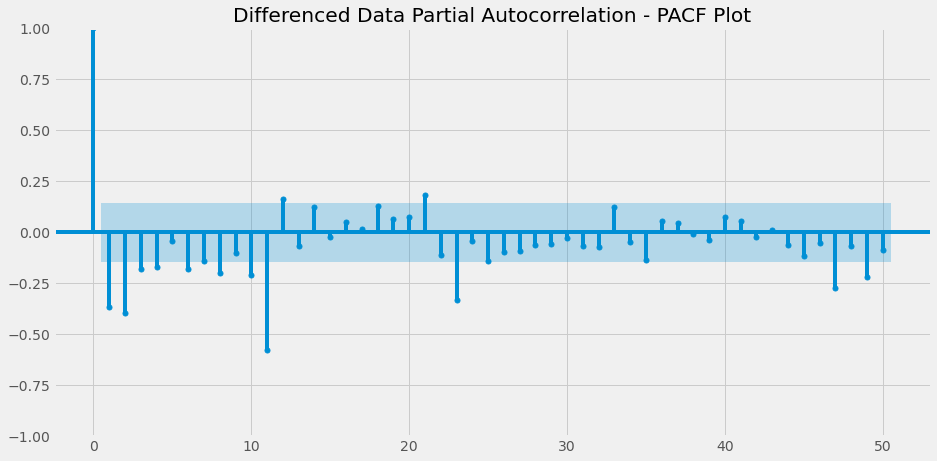

In [474]:
plot_acf(df_wine_rose['Rose'].diff().dropna(),
         lags=50,
         title='Differenced Data Autocorrelation - ACF Plot');
plot_pacf(df_wine_rose['Rose'].diff().dropna(),
          lags=50,
          title='Differenced Data Partial Autocorrelation - PACF Plot');

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 0.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 0.

By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 0. So,our pdq values are 0,1,0
By looking at the above plots, we can say that P = 3 and Q = 1. WE know that D = 1 (seasonal difference), F= 12. Hence the parameter is (0,1,0)(3,1,1,12)

In [591]:
manual_ARIMA = ARIMA(train_rose['Rose'].astype('float64'), order=(0,1,0))

results_manual_ARIMA = manual_ARIMA.fit()

print(results_manual_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -665.577
Date:                Sun, 12 Mar 2023   AIC                           1333.155
Time:                        22:03:23   BIC                           1336.030
Sample:                    01-01-1980   HQIC                          1334.323
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1515.6738    122.418     12.381      0.000    1275.740    1755.608
Ljung-Box (L1) (Q):                  17.11   Jarque-Bera (JB):                59.55
Prob(Q):                              0.00   Pr

We get a comparatively simpler model by looking at the ACF and the PACF plots.

We can see that both the AR(p) and the MA(q) model are of order 4 & 2, we have to convert the input variable into a 'float64' type variable else Python might throw an error when we try to forecast

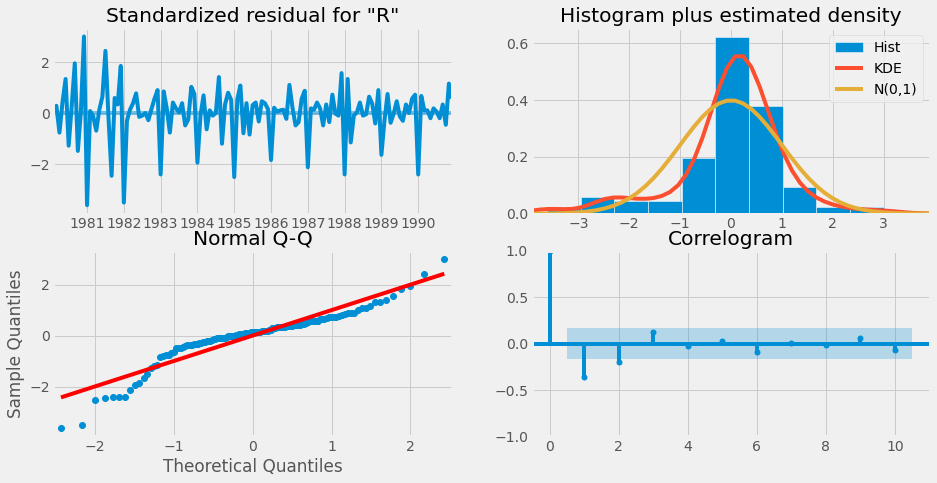

In [592]:
results_manual_ARIMA.plot_diagnostics()
plt.show()

### Predict on the Test Set & Evaluation

In [595]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test_rose))

In [596]:
from statsmodels.tools.eval_measures import rmse
RMSE_manualarima = rmse(test_rose['Rose'],
                        predicted_manual_ARIMA)
RMSE_manualarima
print("The RMSE value of ARIMA (0,1,0) is:",RMSE_manualarima )

The RMSE value of ARIMA (0,1,0) is: 79.71897053798652


In [594]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [RMSE_manualarima]}
                           ,index=['ARIMA(0,1,0) Manual'])


results = pd.concat([results,temp_resultsDf])

results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
2 pointTrailingMovingAverage-Rose Wine              11.529278
4 pointTrailingMovingAverage-Rose Wine              14.451439
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663
ARIMA(2,1,3)                                        35.464266
SARIMA(2,1,3)(2,1,3,6)                              16.742468
SARIMA(0,1,2)(2,1,2,12)                             16.500546
ARIMA(4,1,2) Manual                                 37.037844
SARIMA(4,1,2) (4,1,2,12) Manual                     17.528990
SARIMA(0,1,0) (3,1,1,12) Manual                     14.563221
ARIMA(0,1,0) Manual                                 37.037844

We can see that RMSE value of ARIMA (0,1,0) Model is comparatively less performing than Auto ARIMA and SARIMA model.

### Manual SARIMA MODEL

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 0.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 0.

By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 0. So,our pdq values are 0,1,0
By looking at the above plots, we can say that P = 3 and Q = 1. WE know that D = 1 (seasonal difference), F= 12. Hence the parameter is (0,1,0)(3,1,1,12)

In [548]:
manual_sarima = SARIMAX(train_rose['Rose'],
                                order=(0,1,0),
                                seasonal_order=(3, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_sarima = manual_sarima.fit(maxiter=1000)
results_manual_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 Rose   No. Observations:                  132
Model:             SARIMAX(0, 1, 0)x(3, 1, [1], 12)   Log Likelihood                -369.158
Date:                              Sun, 12 Mar 2023   AIC                            748.317
Time:                                      21:41:28   BIC                            760.411
Sample:                                  01-01-1980   HQIC                           753.175
                                       - 12-01-1990                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0978      0.152      0.642      0.521      -0.201       0.396
ar.S.L24       0.0261      0.089      0.293      0.769      -0.148       0.200
ar.S.L36      -0.0001      0.064     -0.002      0.998      -0.125       0.125
ma.S.L12      -0.8070      0.223     -3.626      0.000      -1.243      -0.371
sigma2       395.6787     76.333      5.184      0.000     246.068     545.290
===================================================================================
Ljung-Box (L1) (Q):                  18.24   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               1.00   Skew:                             0.19
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [552]:
print("The AIC value for full data SARIMAX (0,1,0) (3,1,1,12) is :" , results_manual_sarima.aic)

The AIC value for full data SARIMAX (0,1,0) (3,1,1,12) is : 748.3165246491602


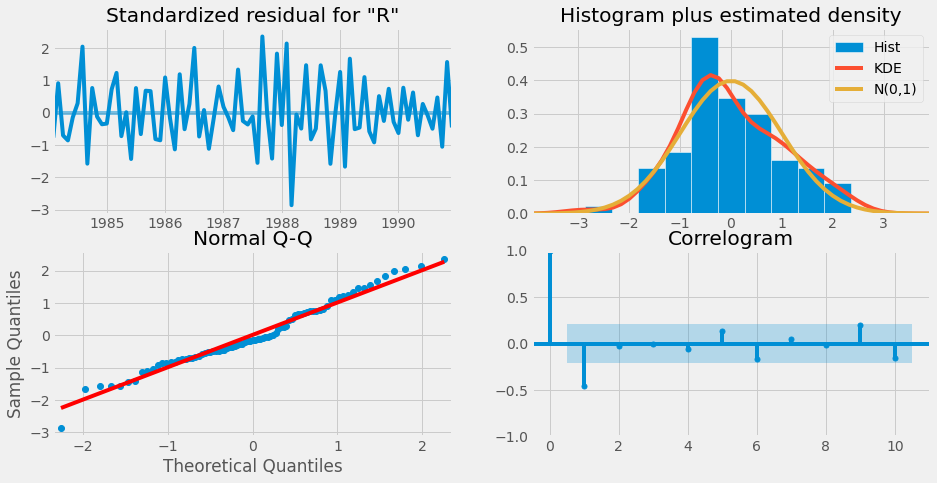

In [553]:
results_manual_sarima.plot_diagnostics()
plt.show()

### Predict on the Test Set & Evaluation

In [560]:
predicted_manual_sarima= results_manual_sarima.get_forecast(steps=len(test_rose))
predicted_manual_sarima.summary_frame(alpha=0.05).head()

Rose             mean    mean_se  mean_ci_lower  mean_ci_upper
1991-01-01  45.936630  19.982192       6.772254      85.101006
1991-02-01  61.625546  28.247755       6.260963     116.990129
1991-03-01  68.627981  34.591666       0.829561     136.426401
1991-04-01  64.277208  39.940344     -14.004428     142.558844
1991-05-01  66.723569  44.652870     -20.794447     154.241585

In [561]:
predicted_manual_sarima.predicted_mean

1991-01-01     45.936630
1991-02-01     61.625546
1991-03-01     68.627981
1991-04-01     64.277208
1991-05-01     66.723569
1991-06-01     68.418819
1991-07-01     72.437773
1991-08-01     72.529011
1991-09-01     77.751067
1991-10-01     74.469509
1991-11-01     97.735792
1991-12-01    126.289475
1992-01-01     40.216083
1992-02-01     55.869738
1992-03-01     62.504176
1992-04-01     57.833660
1992-05-01     61.119196
1992-06-01     62.008780
1992-07-01     66.407735
1992-08-01     67.395684
1992-09-01     71.858867
1992-10-01     69.549045
1992-11-01     91.284814
1992-12-01    120.323806
1993-01-01     34.460324
1993-02-01     49.836813
1993-03-01     56.516873
1993-04-01     51.594879
1993-05-01     55.235702
1993-06-01     55.909704
1993-07-01     60.397507
1993-08-01     61.683509
1993-09-01     65.869748
1993-10-01     64.041004
1993-11-01     85.057527
1993-12-01    114.315605
1994-01-01     28.471325
1994-02-01     43.821172
1994-03-01     50.495700
1994-04-01     45.541898


In [556]:
rmse_sarima = rmse(test_rose['Rose'],
                         predicted_manual_sarima.predicted_mean)

print("The RMSE value of Manual SARIMA(0,1,0)(3,1,1,12) Model is:",rmse_sarima )

The RMSE value of Manual SARIMA(0,1,0)(3,1,1,12) Model is: 14.563221394392732


In [557]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse_sarima]}
                           ,index=['SARIMA(0,1,0) (3,1,1,12) Manual'])


results = pd.concat([results,temp_resultsDf])

results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
2 pointTrailingMovingAverage-Rose Wine              11.529278
4 pointTrailingMovingAverage-Rose Wine              14.451439
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663
ARIMA(2,1,3)                                        35.464266
SARIMA(2,1,3)(2,1,3,6)                              16.742468
SARIMA(0,1,2)(2,1,2,12)                             16.500546
ARIMA(4,1,2) Manual                                 37.037844
SARIMA(4,1,2) (4,1,2,12) Manual                     17.528990
SARIMA(0,1,0) (3,1,1,12) Manual                     14.563221

We can see that RMSE value of SARIMA (0,1,0) (3,1,1,12) Model is Best compared to ARIMA model and other SARIMA models

### 8. Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [597]:
results

Test RMSE
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
2 pointTrailingMovingAverage-Rose Wine              11.529278
4 pointTrailingMovingAverage-Rose Wine              14.451439
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663
ARIMA(2,1,3)                                        35.464266
SARIMA(2,1,3)(2,1,3,6)                              16.742468
SARIMA(0,1,2)(2,1,2,12)                             16.500546
ARIMA(4,1,2) Manual                                 37.037844
SARIMA(4,1,2) (4,1,2,12) Manual                     17.528990
SARIMA(0,1,0) (3,1,1,12) Manual                     14.563221
ARIMA(0,1,0) Manual                                 37.037844

In [599]:
results.sort_values(by='Test RMSE')

Test RMSE
2 pointTrailingMovingAverage-Rose Wine              11.529278
Alpha=0.089,Beta=0.000,Gamma=0.003,TripleExpone...  14.211893
4 pointTrailingMovingAverage-Rose Wine              14.451439
SARIMA(0,1,0) (3,1,1,12) Manual                     14.563221
6 pointTrailingMovingAverage-Rose Wine              14.566381
9 pointTrailingMovingAverage-Rose Wine              14.727663
Alpha = Beta= Negative,SimpleExponentialSmoothi...  15.269008
Alpha=0.0,Beta=1.0,DoubleExponentialSmoothing-R...  15.269016
SARIMA(0,1,2)(2,1,2,12)                             16.500546
SARIMA(2,1,3)(2,1,3,6)                              16.742468
SARIMA(4,1,2) (4,1,2,12) Manual                     17.528990
Alpha=0.0715,Beta=0.045,Gamma=Negative,TripleEx...  20.211817
ARIMA(2,1,3)                                        35.464266
Alpha=0.098,SimpleExponentialSmoothing-Rose Wine    36.796433
ARIMA(4,1,2) Manual                                 37.037844
ARIMA(0,1,0) Manual                                 37.037844
Alpha=0.3,SimpleExponentialSmoothing - Rose Wine    47.817385

We can see that TES Model and SARIMA (0,1,0) (3,1,1,12) Model is Best compared to all other models

### 9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

### Building the most optimum model on the Full Data

In [507]:
fullmodel1 = ExponentialSmoothing(df_wine_rose,
                                  trend='additive',
                                  seasonal='multiplicative').fit(smoothing_level=0.089,
                                                                 smoothing_trend=0.000,
                                                                 smoothing_seasonal=0.003)

In [509]:
fullmodel1.fittedvalues

YearMonth
1980-01-01    107.569432
1980-02-01    121.953591
1980-03-01    133.615086
1980-04-01    118.451298
1980-05-01    127.215073
                 ...    
1995-03-01     37.969594
1995-04-01     34.065146
1995-05-01     38.424655
1995-06-01     40.065117
1995-07-01     44.317058
Length: 187, dtype: float64

In [511]:
RMSE_fullmodel1 = rmse(df_wine_rose['Rose'],fullmodel1.fittedvalues)

RMSE_fullmodel1
print("The RMSE value of TES Model on Full Dataset with Alpha = 0.089,Beta = 0.000,Gamma = 0.003 is:",RMSE_fullmodel1)

The RMSE value of TES Model on Full Dataset with Alpha = 0.089,Beta = 0.000,Gamma = 0.003 is: 16.125543952814112


In [497]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction_1 = fullmodel1.forecast(steps=12)

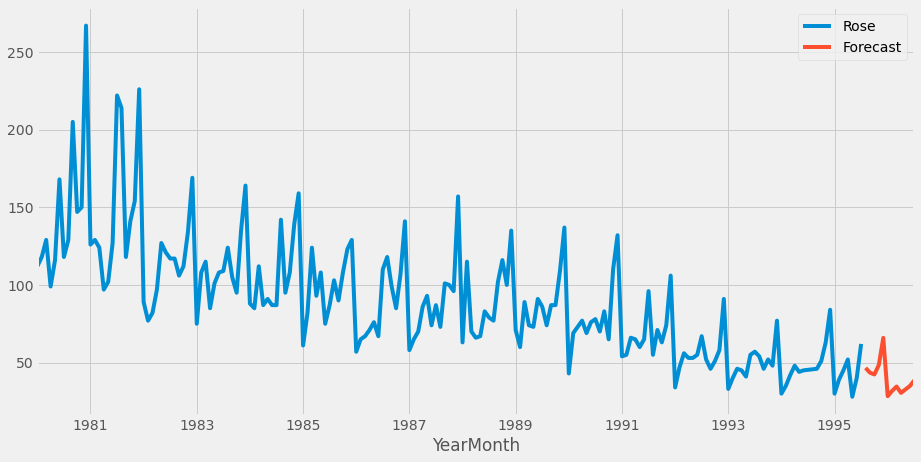

In [500]:
df_wine_rose.plot(legend  = True, label = 'Actual')
prediction_1.plot(legend = True, label = 'Forecast');

### Prediction Confidence Intervals : Margin of Error

One assumption that we have made over here while calculating the confidence bands is that the standard deviation of the forecast distribution is almost equal to the residual standard deviation.

In [501]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level.Here we are taking the multiplier to be 1.96 since in a normal distribution( as the residual should be if you have done the modelling properly,), 95% of values lie within +/- 1.96 sigma of the mean

pred_1_df = pd.DataFrame({'lower_CI':prediction_1 - 1.96*fullmodel1.resid.std(),
                          'prediction':prediction_1,
                          'upper_ci': prediction_1 + 1.96*fullmodel1.resid.std()}).round(0)
pred_1_df.head()

lower_CI  prediction  upper_ci
1995-08-01      15.0        47.0      78.0
1995-09-01      12.0        43.0      75.0
1995-10-01      11.0        42.0      74.0
1995-11-01      17.0        49.0      80.0
1995-12-01      34.0        66.0      98.0

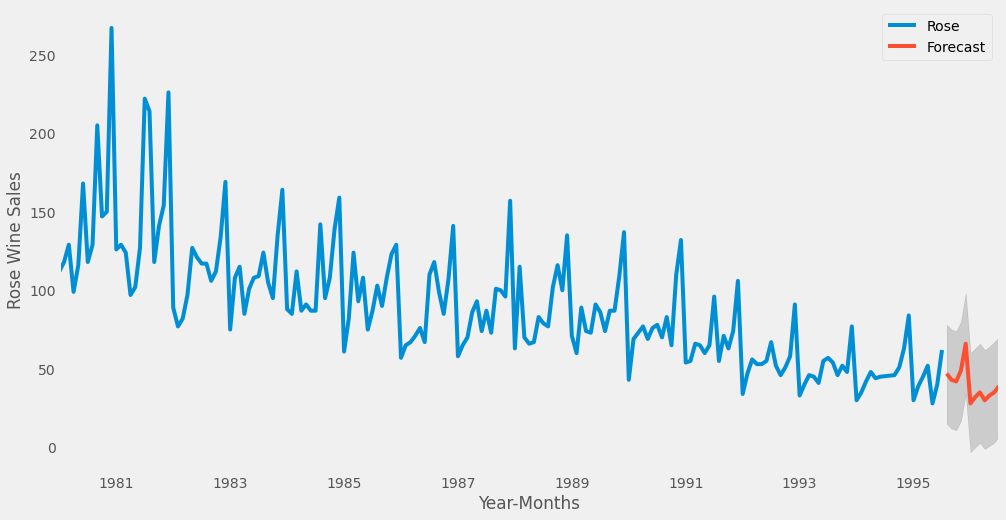

In [504]:
# plot the forecast along with the confidence band

axis = df_wine_rose.plot(label='Actual', figsize=(15,8)) # saving the plot axis to refer to it later for superimposing other plots or add layers to it

pred_1_df['prediction'].plot(ax=axis, label='Forecast', alpha=1) # alpha here is for transparency of the prediction line

# fill_between function shades a specified region in the plot. The region's bounds are specified as the x axis values and y axis values

axis.fill_between(pred_1_df.index, 
                  pred_1_df['lower_CI'], 
                  pred_1_df['upper_ci'], 
                  color='Black', 
                  alpha=.15) # alpha here denotes the transparency of the shaded region

axis.set_xlabel('Year-Months')
axis.set_ylabel('Rose Wine Sales')
plt.legend(loc='best')
plt.grid();

**Inference**

•	From the above plot the TES Model with “multiplicative” seasonality is performing well.

•	We can see that the future 12 months of Rose Wine sales are fluctuating with decreasing Trend


## SARIMAX Model on Full Data

In [579]:
full_data_model = SARIMAX(df_wine_rose['Rose'],
                                order=(0,1,2),
                                seasonal_order=(2, 1,2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
results_full_data_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Rose   No. Observations:                  187
Model:             SARIMAX(0, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -588.601
Date:                            Sun, 12 Mar 2023   AIC                           1191.202
Time:                                    21:58:16   BIC                           1212.135
Sample:                                01-01-1980   HQIC                          1199.707
                                     - 07-01-1995                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8258      0.080    -10.338      0.000      -0.982      -0.669
ma.L2         -0.0801      0.086     -0.927      0.354      -0.250       0.089
ar.S.L12       0.0642      0.159      0.403      0.687      -0.248       0.376
ar.S.L24      -0.0339      0.019     -1.795      0.073      -0.071       0.003
ma.S.L12      -0.6963      0.207     -3.370      0.001      -1.101      -0.291
ma.S.L24      -0.0552      0.150     -0.368      0.713      -0.349       0.238
sigma2       166.0332     17.897      9.277      0.000     130.956     201.111
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 8.23
Prob(Q):                              0.79   Prob(JB):                         0.02
Heteroskedasticity (H):               0.51   Skew:                             0.33
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [580]:
## AIC value

print("The AIC value for full data SARIMAX (0,1,2) (2,1,2,12) is :" , results_full_data_model.aic)

The AIC value for full data SARIMAX (0,1,2) (2,1,2,12) is : 1191.2017650715136


### Evaluating the model on the whole and predicting 12 months into the future 

In [581]:
predicted_manual_SARIMA_6_full_data = results_full_data_model.get_forecast(steps=12)

In [582]:
predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).head()

Rose             mean    mean_se  mean_ci_lower  mean_ci_upper
1995-08-01  43.466525  12.887907      18.206691      68.726359
1995-09-01  43.570909  13.082079      17.930505      69.211313
1995-10-01  45.551301  13.138136      19.801028      71.301573
1995-11-01  57.605972  13.193963      31.746279      83.465665
1995-12-01  85.083345  13.249576      59.114652     111.052038

In [583]:
rmse_full_data = rmse(df_wine_rose['Rose'],results_full_data_model.fittedvalues)
rmse_full_data
print("The RMSE value of SARIMA (0,1,2) (2,1,2,12) Model on Full Rose Wine Dataset is:",rmse_full_data )

The RMSE value of SARIMA (0,1,2) (2,1,2,12) Model on Full Rose Wine Dataset is: 33.47838619388035


The above RMSE is on the training data predictions only. We cannot calculate RMSE for forecast as the actual values(which have not occured yet) are not available for it to be compared with the forecasted value.

In [281]:
pred_full_manual_SARIMA_data = predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).set_index(pd.date_range(start='1995-08-01',end='1996-07-31', freq='M'))

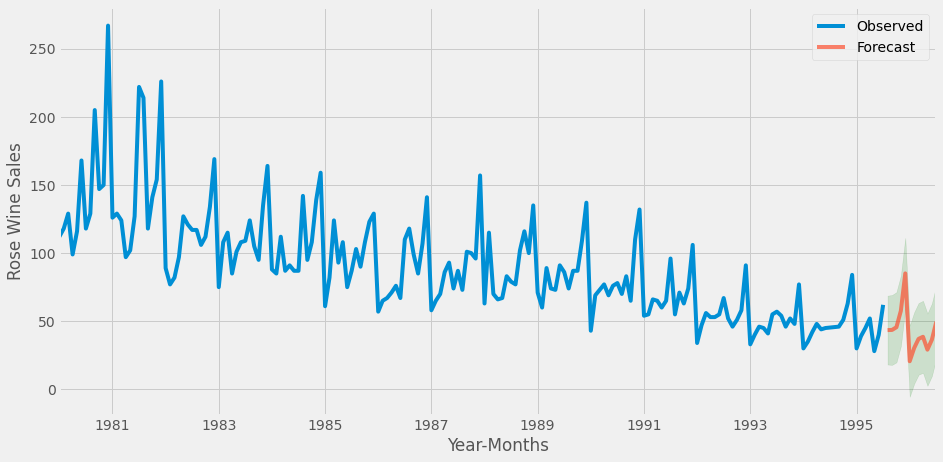

In [514]:
# plot the forecast along with the confidence band

axis = df_wine_rose['Rose'].plot(label='Observed')

pred_full_manual_SARIMA_data['mean'].plot(ax=axis, label='Forecast', alpha=0.7)

axis.fill_between(pred_full_manual_SARIMA_data.index, 
                  pred_full_manual_SARIMA_data['mean_ci_lower'], 
                  pred_full_manual_SARIMA_data['mean_ci_upper'], 
                  color='green', alpha=.15)

axis.set_xlabel('Year-Months')
axis.set_ylabel('Rose Wine Sales')
plt.legend(loc='best')
plt.show()

**Inference**

 * The SARIMA (0,1,2) (2,1,2,12) gives lesser RMSE compared to SARIMA (0,1,0) (3,1,1,12). Hence the Best optimum model is built on that.
 

### Moving Average(MA) Model on Full Data

In [482]:
MovingAverage_full = df_wine_rose.copy()
MovingAverage_full.head(5)

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

**Trailing moving averages**

In [485]:
MovingAverage_full['Trailing_2'] = MovingAverage_full['Rose'].rolling(2).mean()

In [486]:
MovingAverage_full.head(10)

Rose  Trailing_2
YearMonth                    
1980-01-01  112.0         NaN
1980-02-01  118.0       115.0
1980-03-01  129.0       123.5
1980-04-01   99.0       114.0
1980-05-01  116.0       107.5
1980-06-01  168.0       142.0
1980-07-01  118.0       143.0
1980-08-01  129.0       123.5
1980-09-01  205.0       167.0
1980-10-01  147.0       176.0

In [487]:
MovingAverage_full.tail(10)

Rose  Trailing_2
YearMonth                   
1994-10-01  51.0        48.5
1994-11-01  63.0        57.0
1994-12-01  84.0        73.5
1995-01-01  30.0        57.0
1995-02-01  39.0        34.5
1995-03-01  45.0        42.0
1995-04-01  52.0        48.5
1995-05-01  28.0        40.0
1995-06-01  40.0        34.0
1995-07-01  62.0        51.0

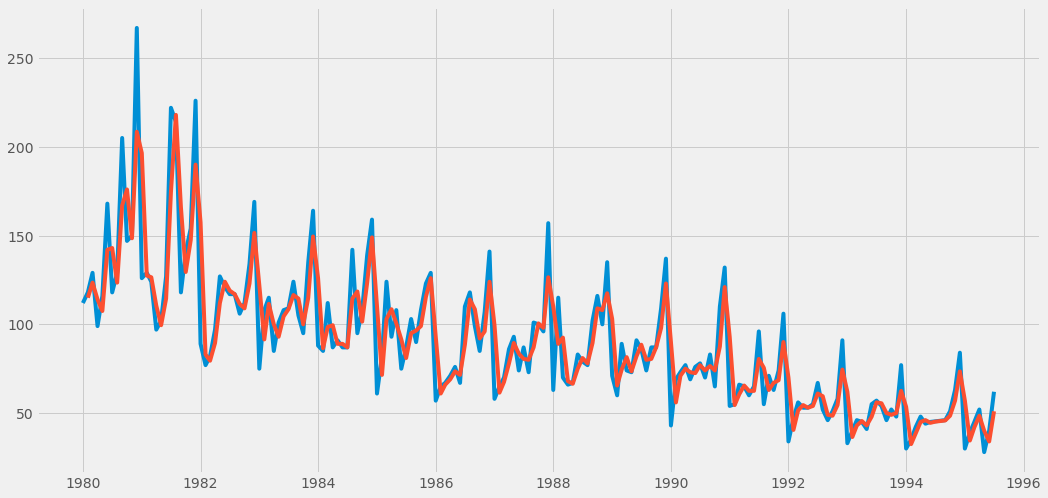

In [488]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(MovingAverage_full['Rose'], label='Train')
plt.plot(MovingAverage_full['Trailing_2'], label='2 Point Moving Average');

**Inference**

 * 
 * 

### 10. Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.
Please explain and summarise the various steps performed in this project. There should be proper business interpretation and actionable insights present.

Given in the Report.